In [1]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

# ML utilities
from sklearn.preprocessing import StandardScaler

# Display settings
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", "{:.4f}".format)
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 6)


In [2]:
#Reading Backblaze Data
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone640/Backblaze_sample_20to25.csv',low_memory=False)
data.head()

print("Dataset shape:", data.shape)


Mounted at /content/drive
Dataset shape: (259152, 13)


In [3]:
df=data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259152 entries, 0 to 259151
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   date                                259152 non-null  object 
 1   serial_number                       259152 non-null  object 
 2   model                               259152 non-null  object 
 3   capacity_bytes                      259152 non-null  int64  
 4   failure                             259152 non-null  int64  
 5   reallocated_sector_count            256725 non-null  float64
 6   reported_uncorrectable_errors       106337 non-null  float64
 7   command_timeout_count               105506 non-null  float64
 8   current_pending_sector_count        253663 non-null  float64
 9   offline_uncorrectable_sector_count  256623 non-null  float64
 10  udma_crc_error_count                256725 non-null  float64
 11  drive_temperature_vendor_1

In [4]:
#Memory Analysis
(df.memory_usage(deep=True).sum() / 1024**2)


np.float64(65.06015300750732)

In [5]:
#Missing Value Analysis
missing = df.isna().mean().sort_values(ascending=False)
missing[missing > 0]


drive_temperature_vendor_190         0.5934
command_timeout_count                0.5929
reported_uncorrectable_errors        0.5897
current_pending_sector_count         0.0212
offline_uncorrectable_sector_count   0.0098
udma_crc_error_count                 0.0094
reallocated_sector_count             0.0094
drive_temperature_vendor_194         0.0014
dtype: float64

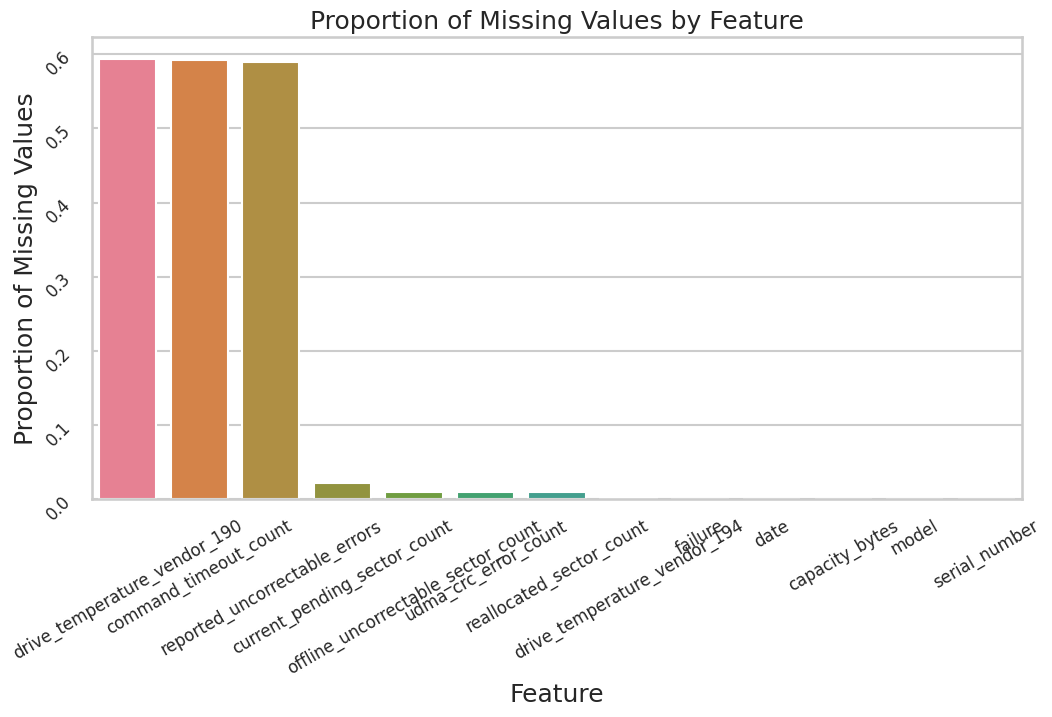

In [6]:
#Visualizing the missing value by feature
plt.figure(figsize=(12, 6))
sns.barplot(x=missing.index, y=missing.values, hue=missing.index, legend=False)
plt.title("Proportion of Missing Values by Feature")
plt.xlabel("Feature")
plt.ylabel("Proportion of Missing Values")
plt.xticks(rotation=30, fontsize=12)
plt.yticks(rotation=45, fontsize=12)
plt.show()

In [7]:
#Duplicate and Integrity Checks
print("Duplicate rows:", df.duplicated().sum())



Duplicate rows: 1


In [8]:
#Drop duplicate records
df.drop_duplicates(inplace=True)
print("DataFrame shape after dropping duplicates:", df.shape)

DataFrame shape after dropping duplicates: (259151, 13)


In [9]:
#Proportion of Failure (positive) and Non-Failure(negative) values
df["failure"].value_counts(normalize=True)

failure
0   0.9375
1   0.0625
Name: proportion, dtype: float64

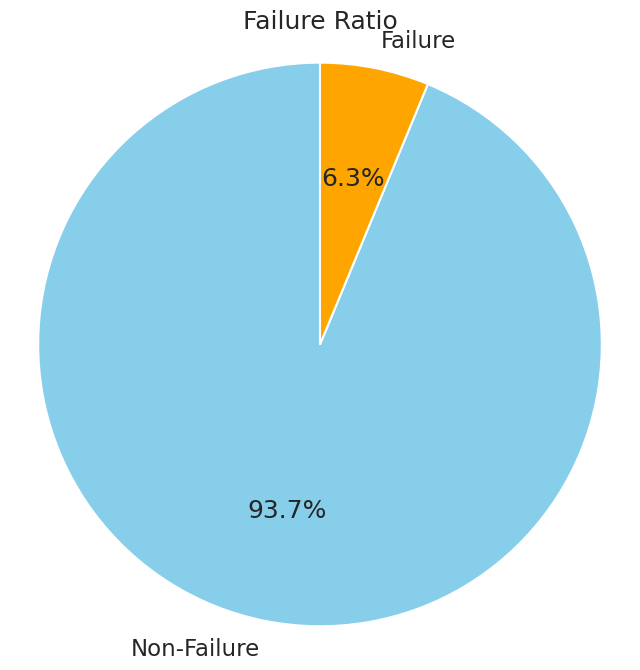

In [10]:
failure_counts = df['failure'].value_counts()
labels = ['Non-Failure', 'Failure']

plt.figure(figsize=(8, 8))
plt.pie(failure_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title('Failure Ratio')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

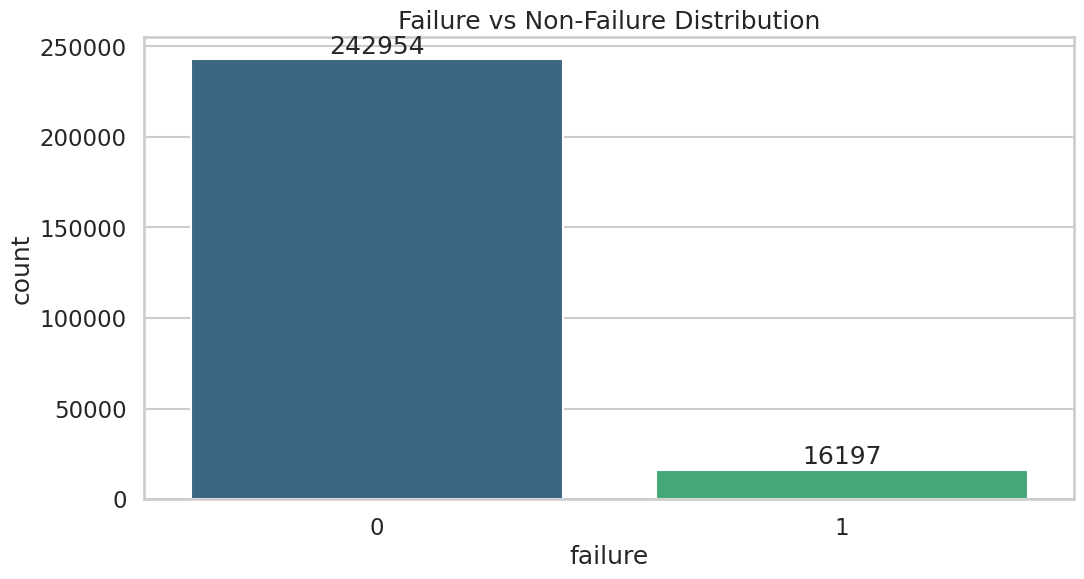

In [11]:
# Target Variable Analysis
ax = sns.countplot(x="failure", data=df, palette='viridis', hue='failure', legend=False)
plt.title("Failure vs Non-Failure Distribution")

# Add exact failure numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

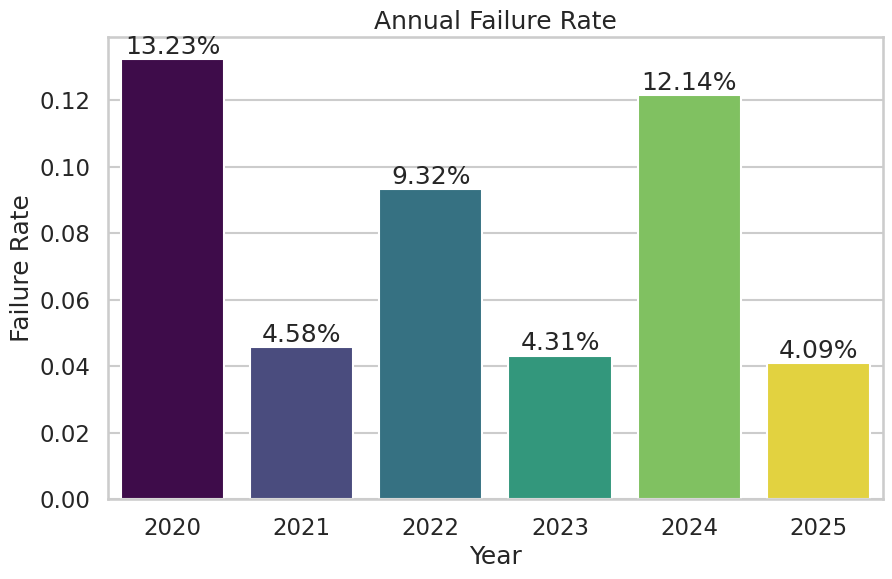

In [12]:
#Failure Rate By Year

df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

failure_by_year = df.groupby("year")["failure"].mean()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=failure_by_year.index, y=failure_by_year.values, palette='viridis', hue=failure_by_year.index, legend=False)
plt.xlabel("Year")
plt.ylabel("Failure Rate")
plt.title("Annual Failure Rate")

# Add exact percentage on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.show()

In [13]:
#Feature Set Definition
features = [
    "reallocated_sector_count",
    "reported_uncorrectable_errors",
    "command_timeout_count",
    "current_pending_sector_count",
    "offline_uncorrectable_sector_count",
    "udma_crc_error_count",
    "drive_temperature_vendor_190",
    "drive_temperature_vendor_194"
]

features = [f for f in features if f in df.columns]


In [14]:
#Descriptive Statistics (Failure vs Non-Failure)
descriptive_stats = pd.DataFrame(df.groupby("failure")[features].describe().T)
display(descriptive_stats)

failure                                      0          1
reallocated_sector_count     count 240700.0000 16024.0000
                             mean     101.4808    97.7516
                             std       14.9378    18.9473
                             min        1.0000     1.0000
                             25%      100.0000   100.0000
...                                        ...        ...
drive_temperature_vendor_194 min       14.0000    15.0000
                             25%       32.0000    30.0000
                             50%       64.0000    41.0000
                             75%      100.0000   100.0000
                             max      253.0000   253.0000

[64 rows x 2 columns]

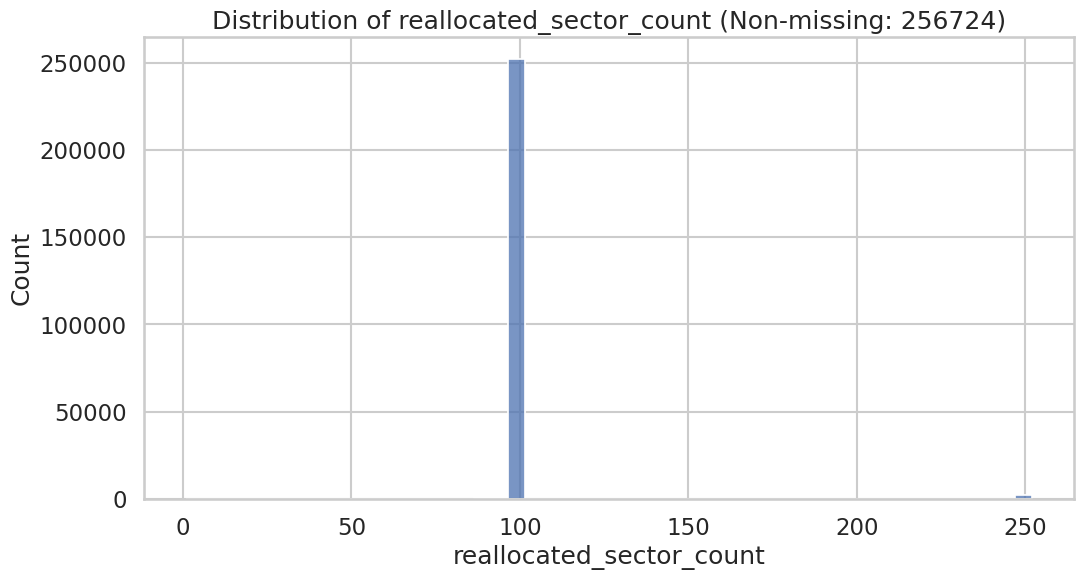

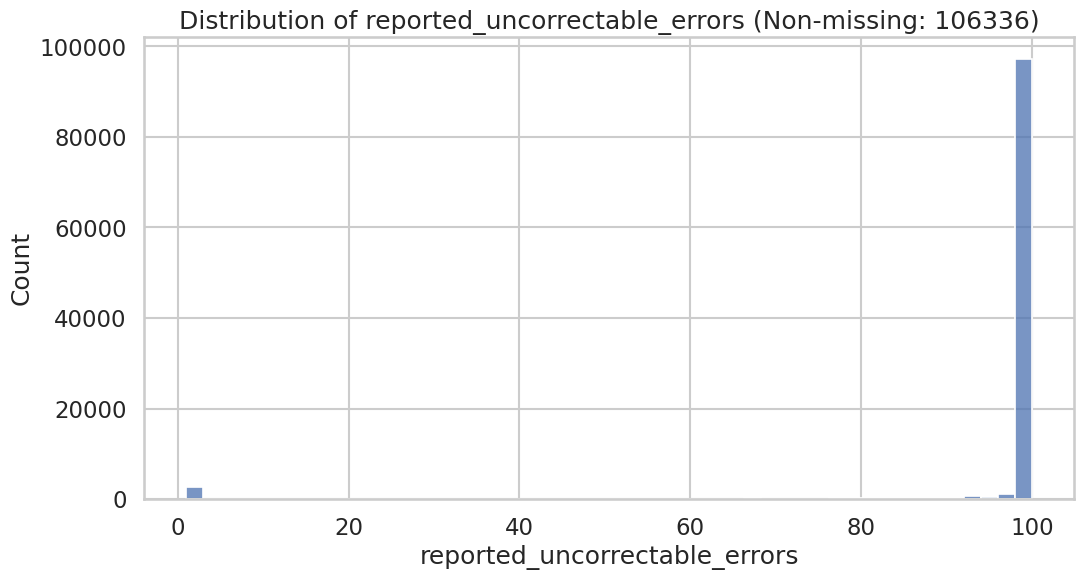

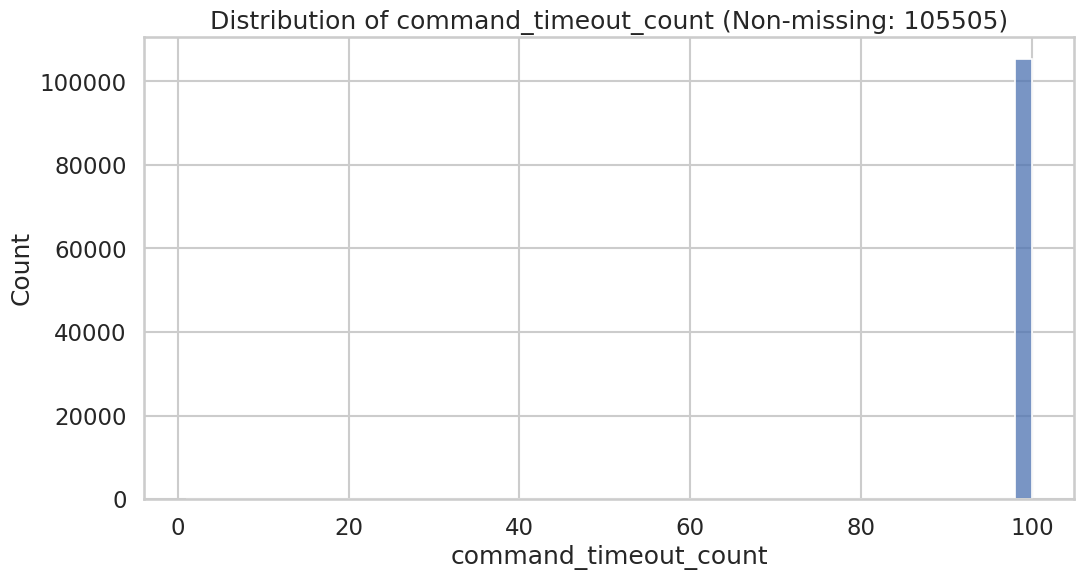

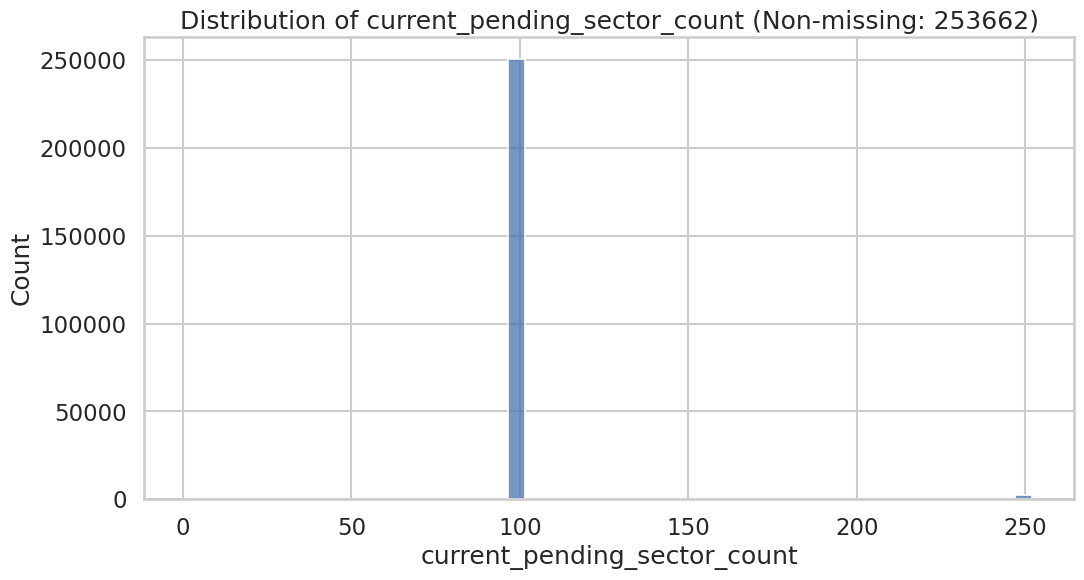

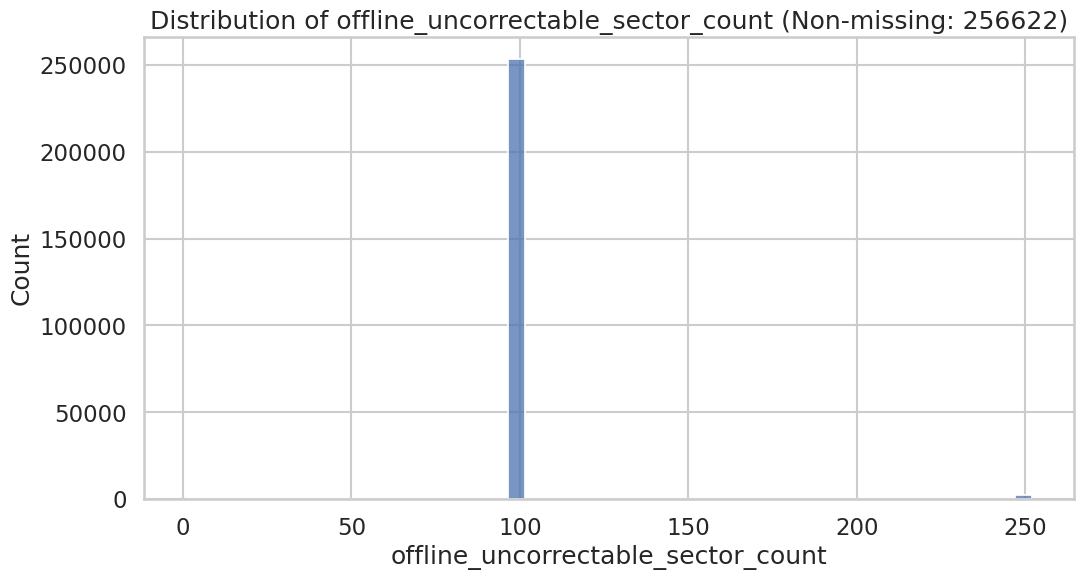

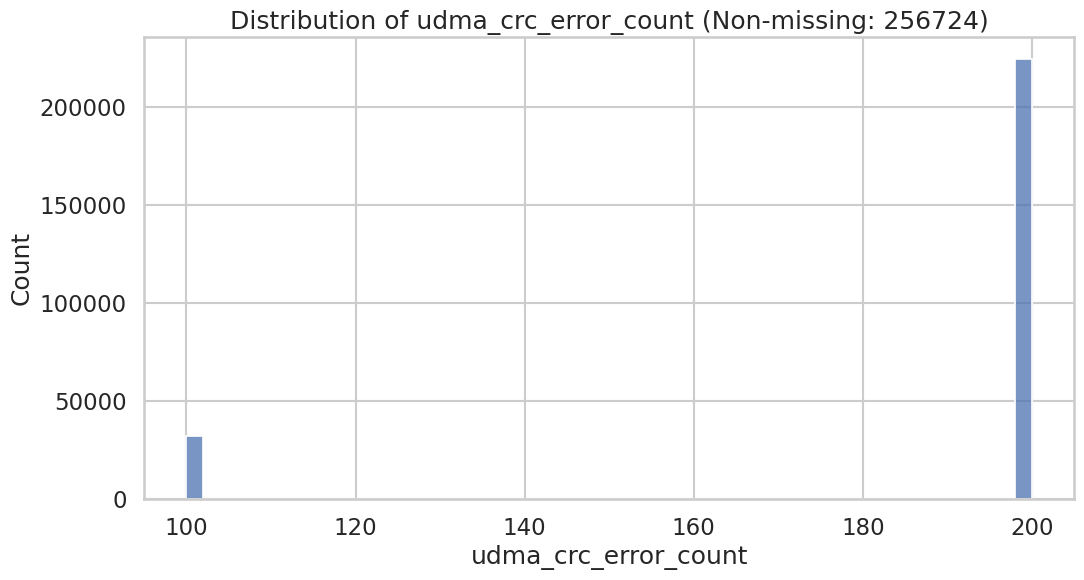

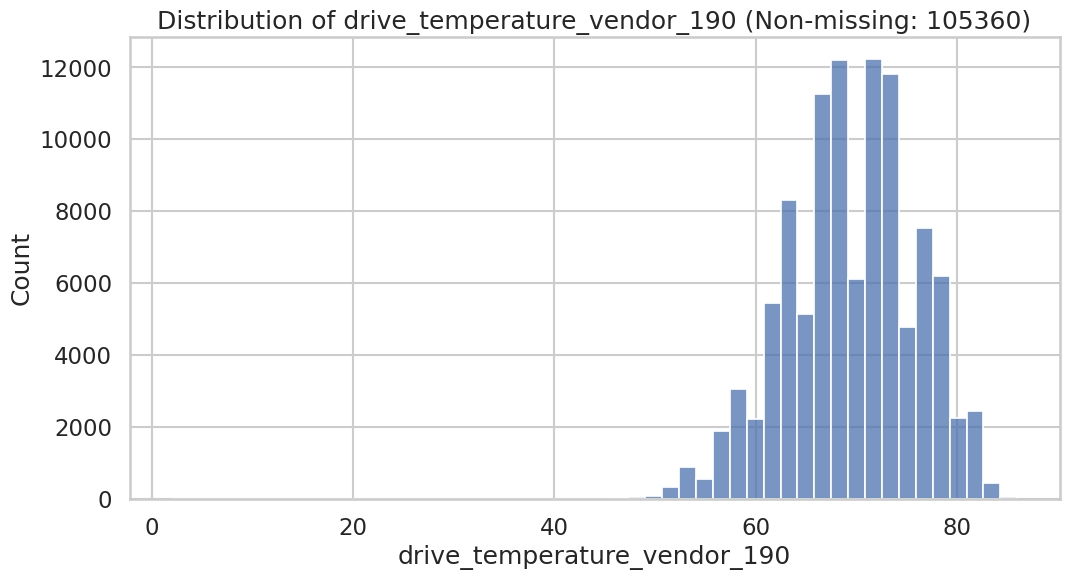

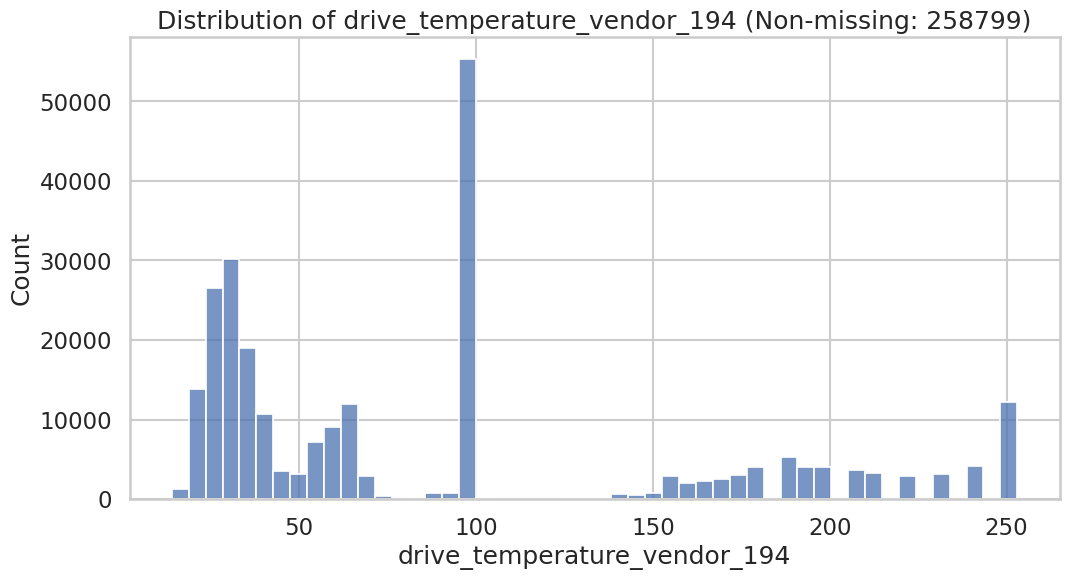

In [15]:
# Distributional Analysis
# Histograms (Log-scaled where appropriate)
for col in features:
    plt.figure()
    non_missing_count = df[col].count()
    if non_missing_count > 0:
        # Removed log_scale=(False, True) to better visualize concentrated data
        sns.histplot(df[col].dropna(), bins=50)
        plt.title(f"Distribution of {col} (Non-missing: {non_missing_count})")
    else:
        plt.title(f"No data to display for {col} (Non-missing: {non_missing_count})")
    plt.show()

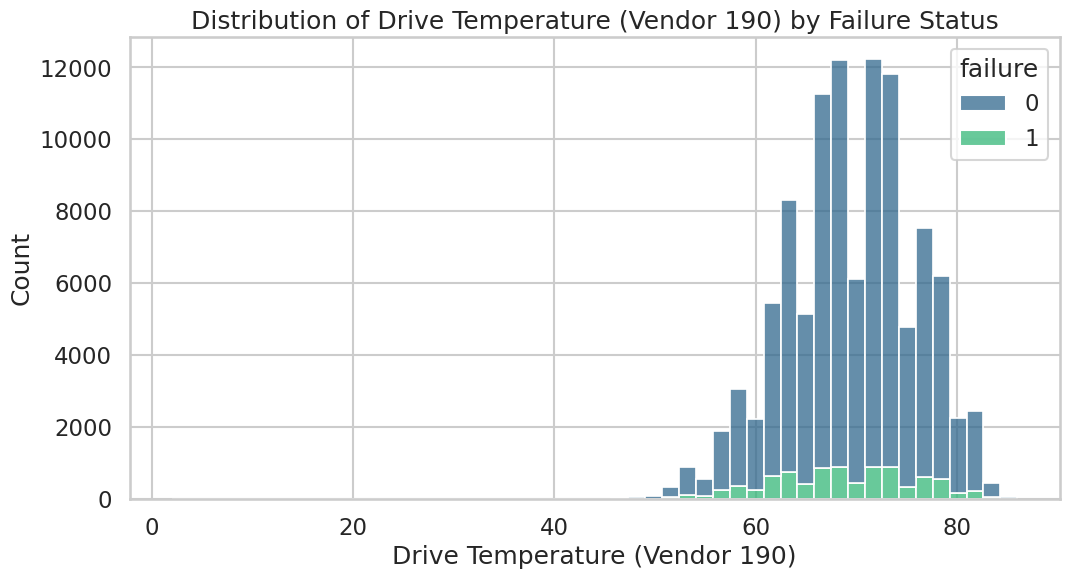

In [16]:
# Stacked Histogram for drive_temperature_vendor_190
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='drive_temperature_vendor_190', hue='failure', multiple='stack', bins=50, palette='viridis', legend=True)
plt.title('Distribution of Drive Temperature (Vendor 190) by Failure Status')
plt.xlabel('Drive Temperature (Vendor 190)')
plt.ylabel('Count')
plt.show()

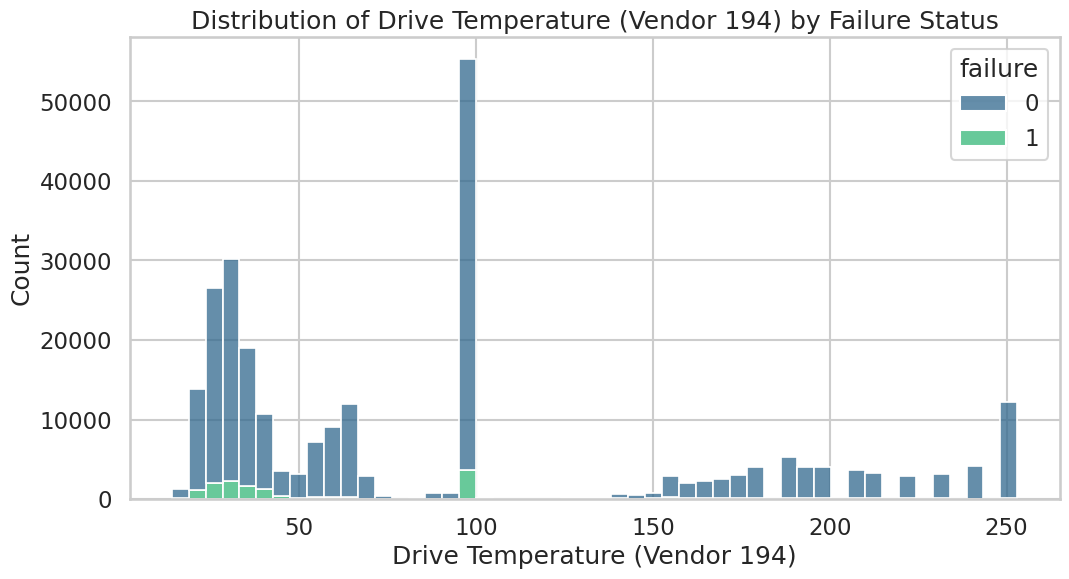

In [17]:
# Stacked Histogram for drive_temperature_vendor_194
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='drive_temperature_vendor_194', hue='failure', multiple='stack', bins=50, palette='viridis', legend=True)
plt.title('Distribution of Drive Temperature (Vendor 194) by Failure Status')
plt.xlabel('Drive Temperature (Vendor 194)')
plt.ylabel('Count')
plt.show()

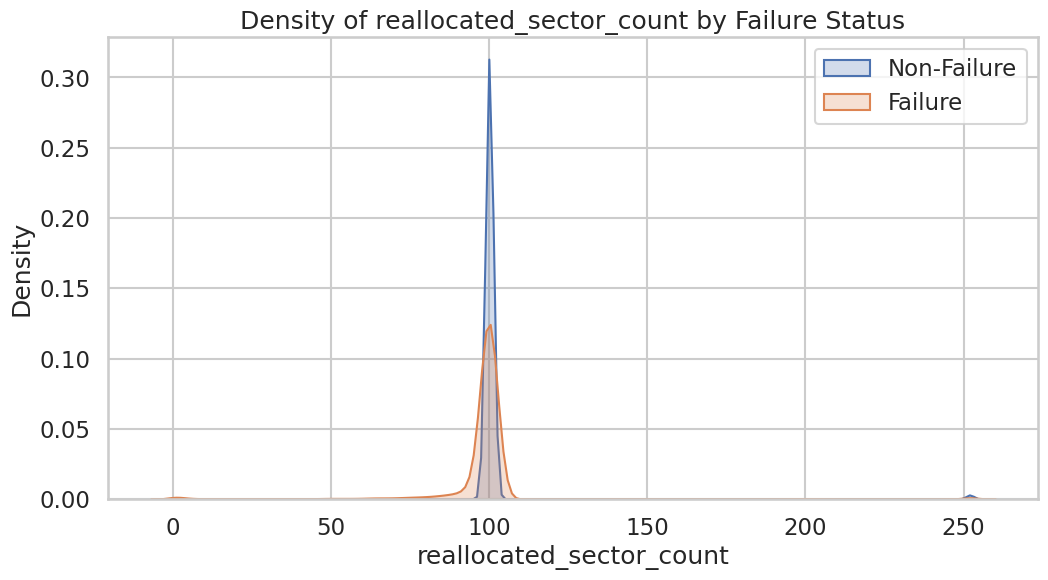

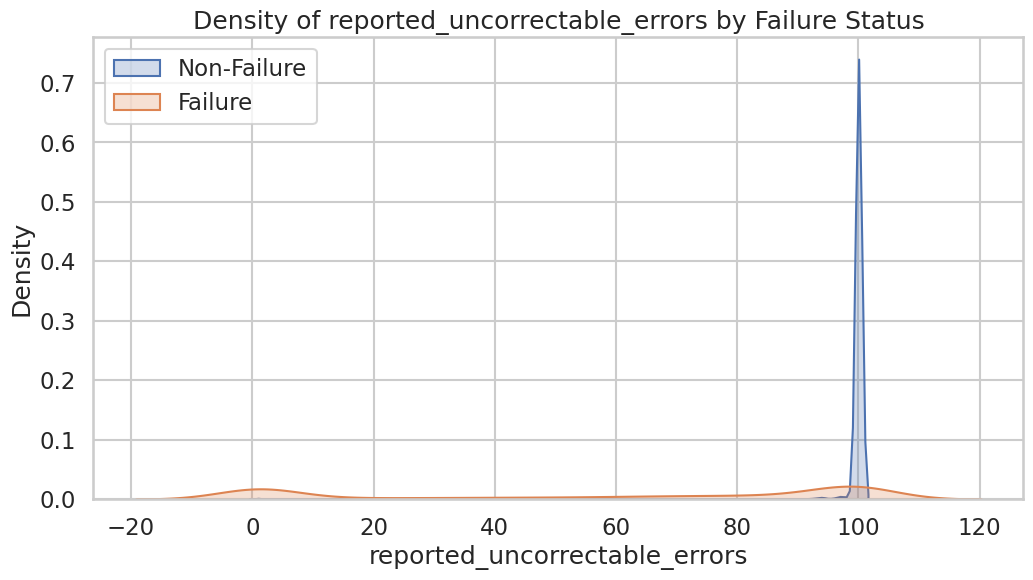

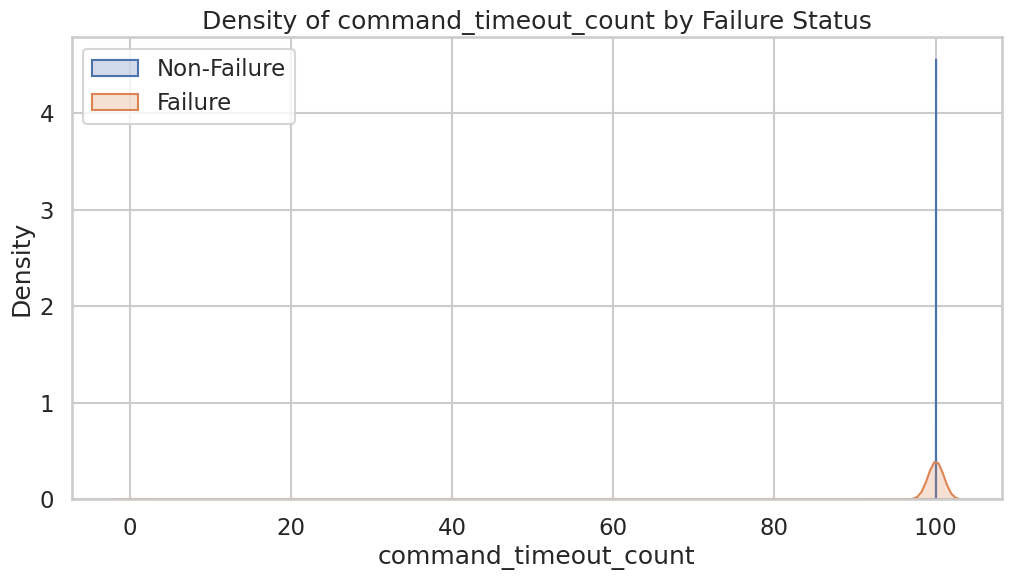

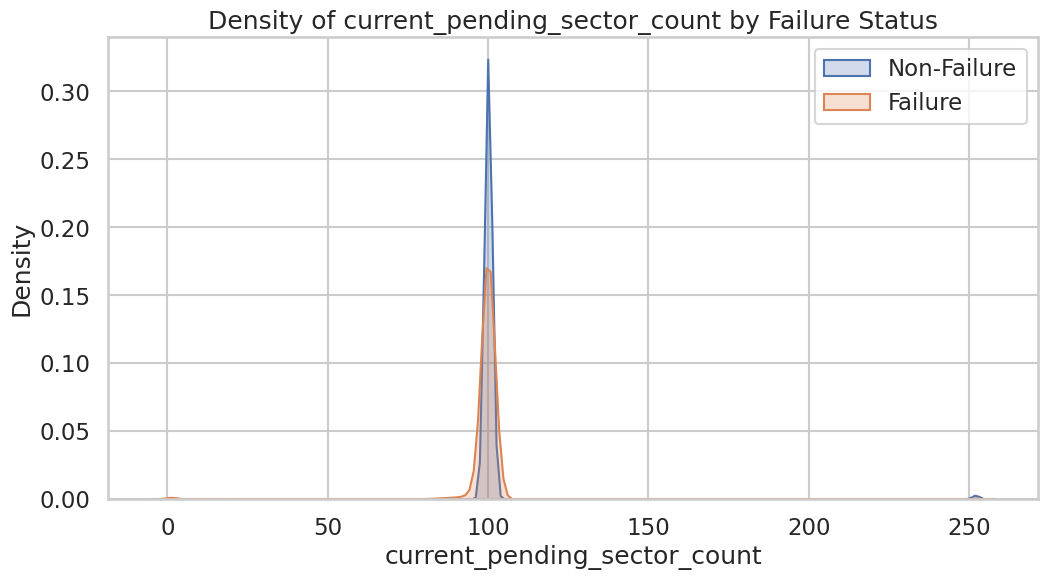

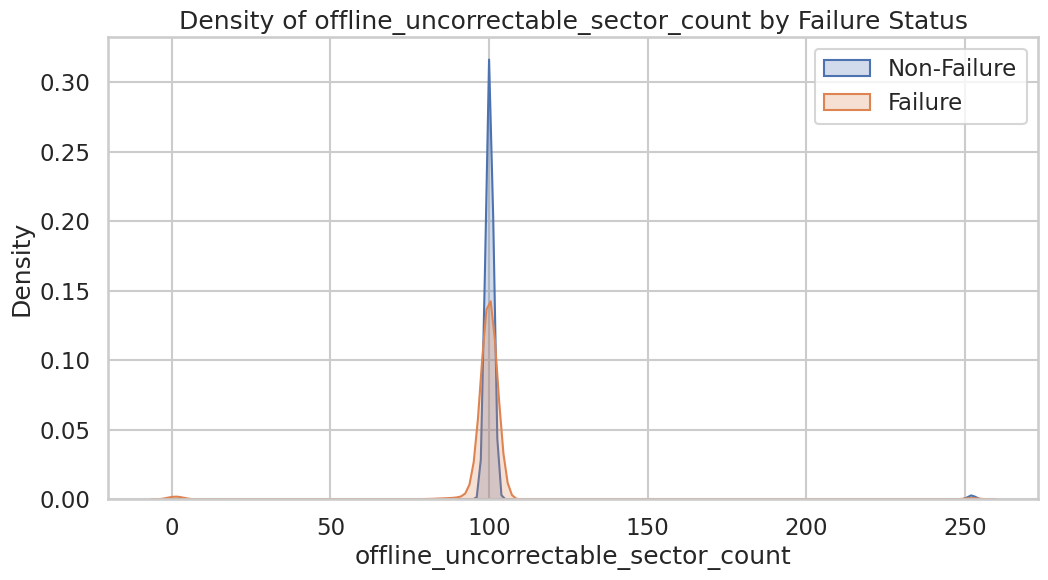

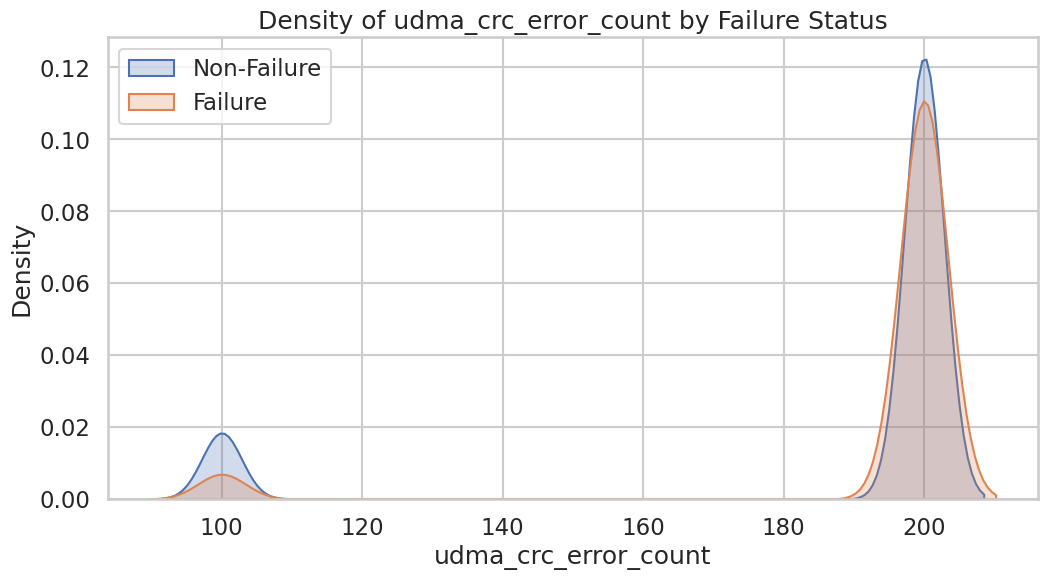

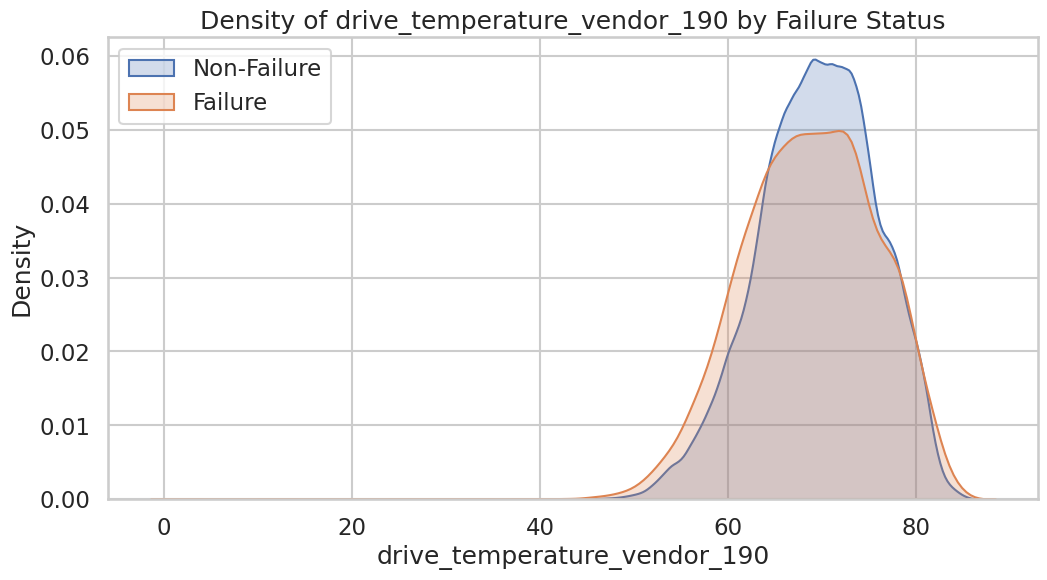

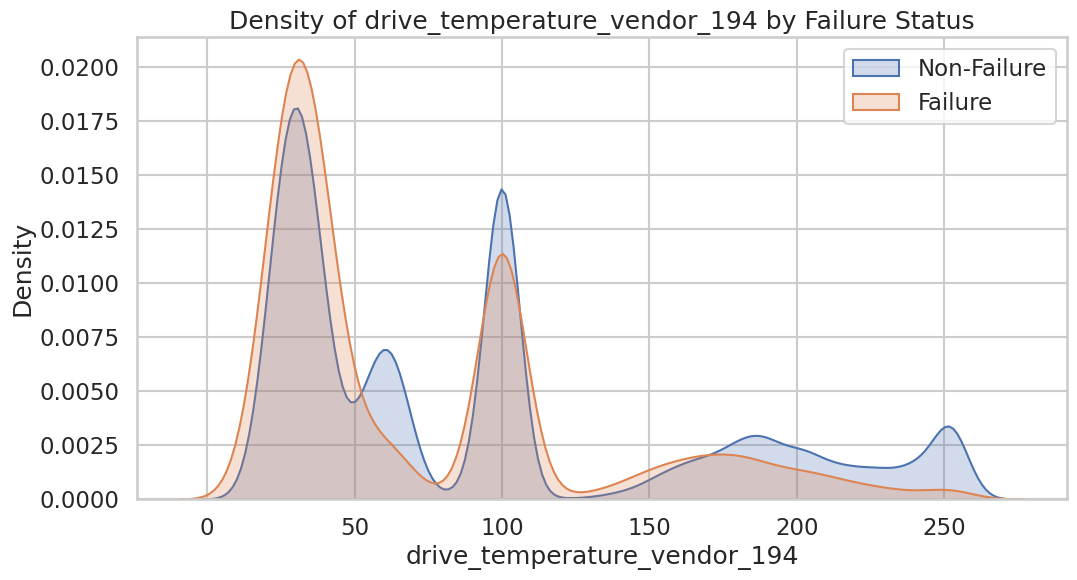

In [18]:
#Class Conditional analysis

for col in features:
    plt.figure()
    sns.kdeplot(df[df.failure == 0][col], label="Non-Failure", fill=True)
    sns.kdeplot(df[df.failure == 1][col], label="Failure", fill=True)
    plt.title(f"Density of {col} by Failure Status")
    plt.legend()
    plt.show()


reallocated_sector_count: The density plots for reallocated_sector_count show very little difference between failing and non-failing drives, with both distributions heavily concentrated around 100. This suggests that this feature, as measured, may not be a strong indicator of impending failure.

reported_uncorrectable_errors: For reported_uncorrectable_errors, the density is heavily concentrated at 0 for non-failing drives, while failing drives show a broader, albeit still low-magnitude, distribution with some density at higher values. This implies that the presence of reported_uncorrectable_errors might be slightly more indicative of failure.

command_timeout_count: Similar to reported_uncorrectable_errors, command_timeout_count shows a concentration at 0 for non-failing drives. Failing drives again exhibit a slightly wider distribution with some density at higher values, suggesting a potential, though weak, link to failure.

current_pending_sector_count: This feature also shows a high density at 0 for non-failing drives. Failing drives, however, show a noticeable shift, with a higher density at values greater than 0, indicating that an increase in current_pending_sector_count is more prevalent in failing drives.

offline_uncorrectable_sector_count: This feature displays a clear distinction. Non-failing drives are almost exclusively concentrated at 0. In contrast, failing drives show a significantly higher density spread across various non-zero values, indicating that an elevated offline_uncorrectable_sector_count is a strong predictor of drive failure.

udma_crc_error_count: The distributions for udma_crc_error_count are very similar for both failing and non-failing drives, both peaking at 0 with a rapid drop-off. This suggests it might not be a strong differentiating factor for failure.

drive_temperature_vendor_190: The density plots for drive_temperature_vendor_190 are largely overlapping for both failure statuses. While there are some minor differences in shape, they don't suggest a significant difference in temperature distribution between failing and non-failing drives for this vendor's sensor.

drive_temperature_vendor_194: Similar to drive_temperature_vendor_190, the distributions for drive_temperature_vendor_194 overlap considerably, indicating that this temperature metric, within its observed range, does not appear to be a primary differentiator between failing and non-failing drives.

In summary, offline_uncorrectable_sector_count and current_pending_sector_count appear to be the most promising indicators of impending failure among the features analyzed, showing distinct differences in their distributions between failing and non-failing drives. The temperature metrics and reallocated_sector_count show less discriminatory power.

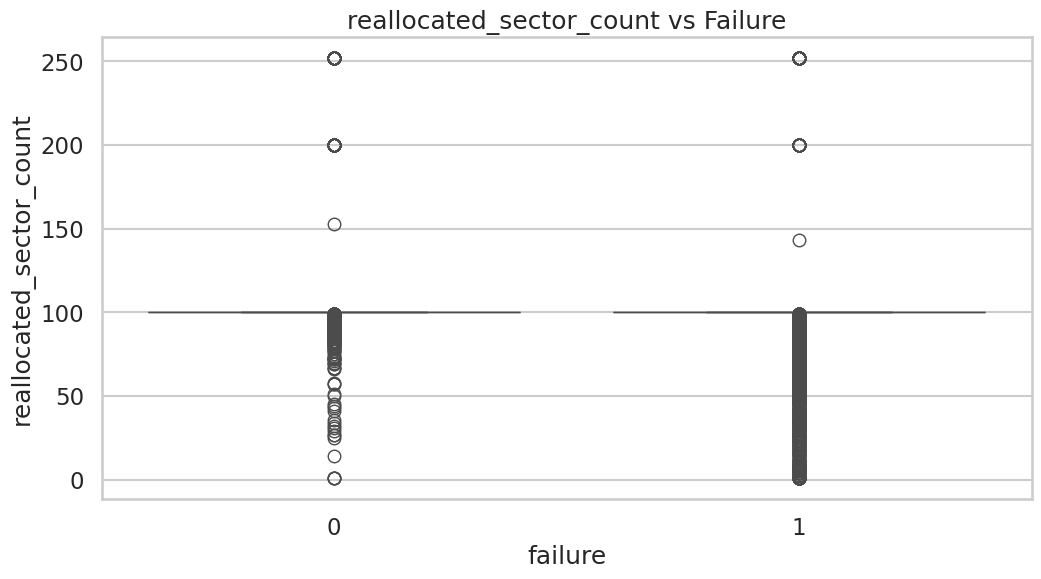

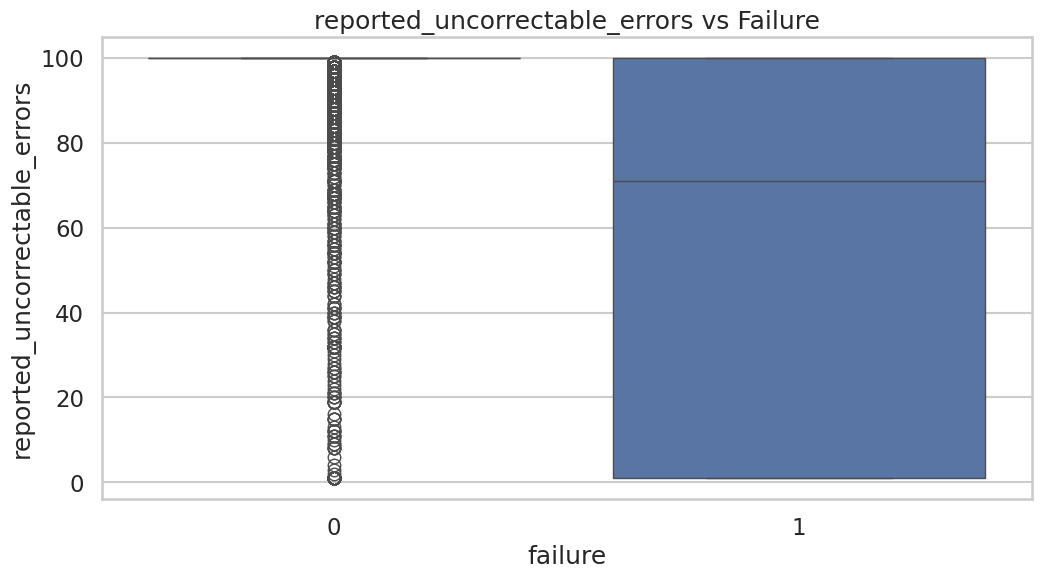

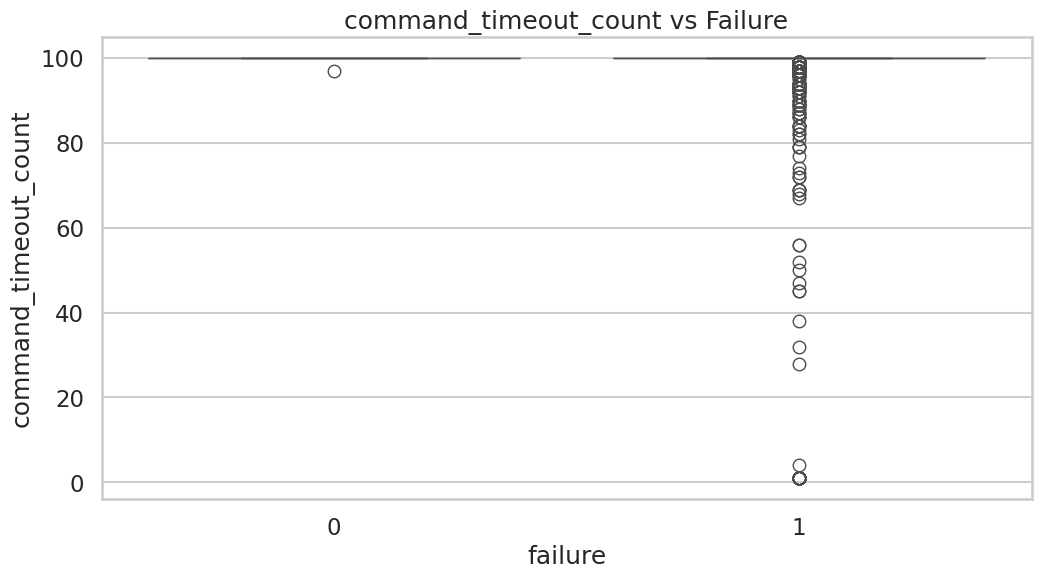

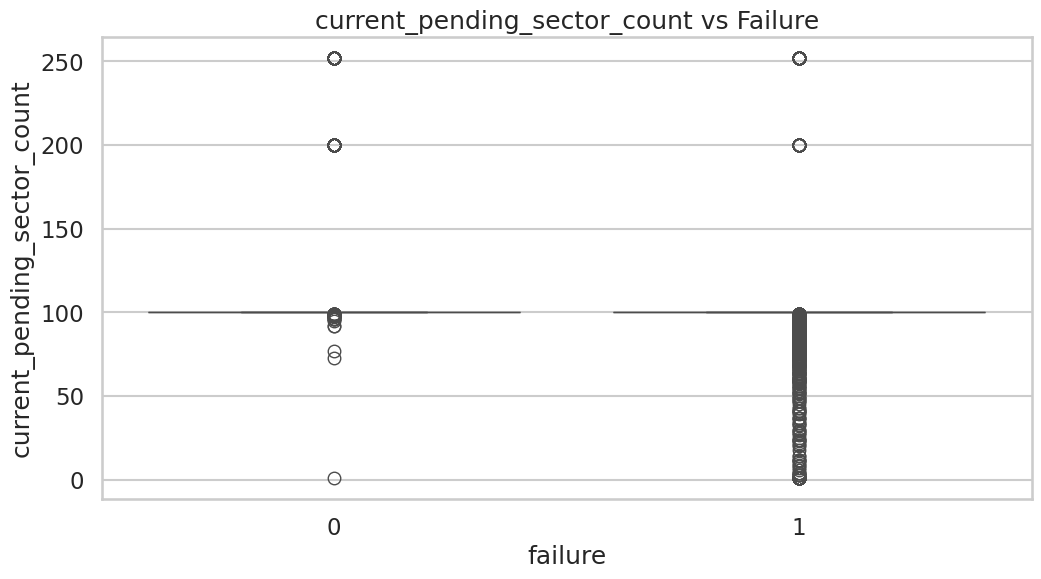

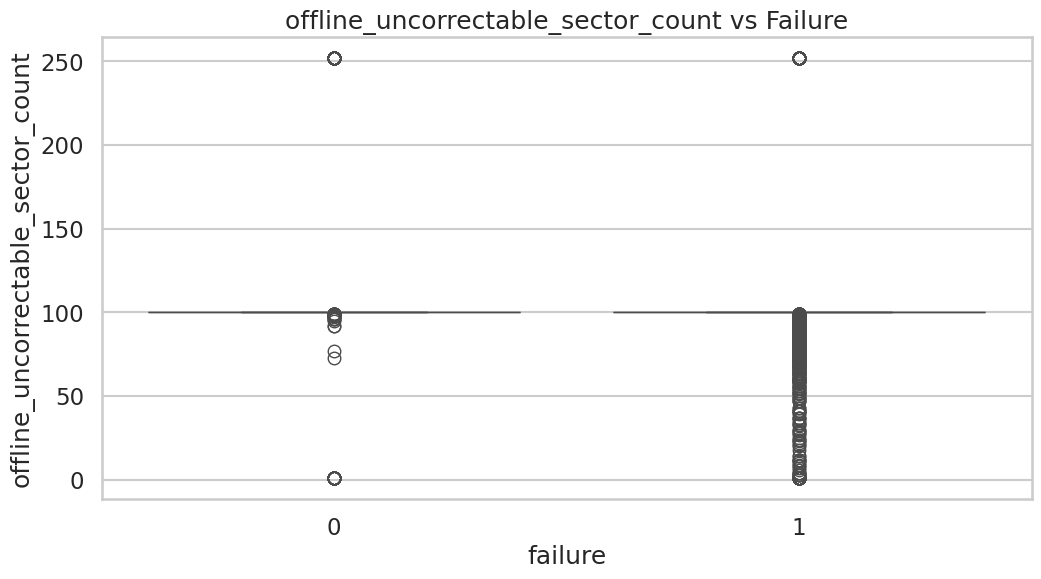

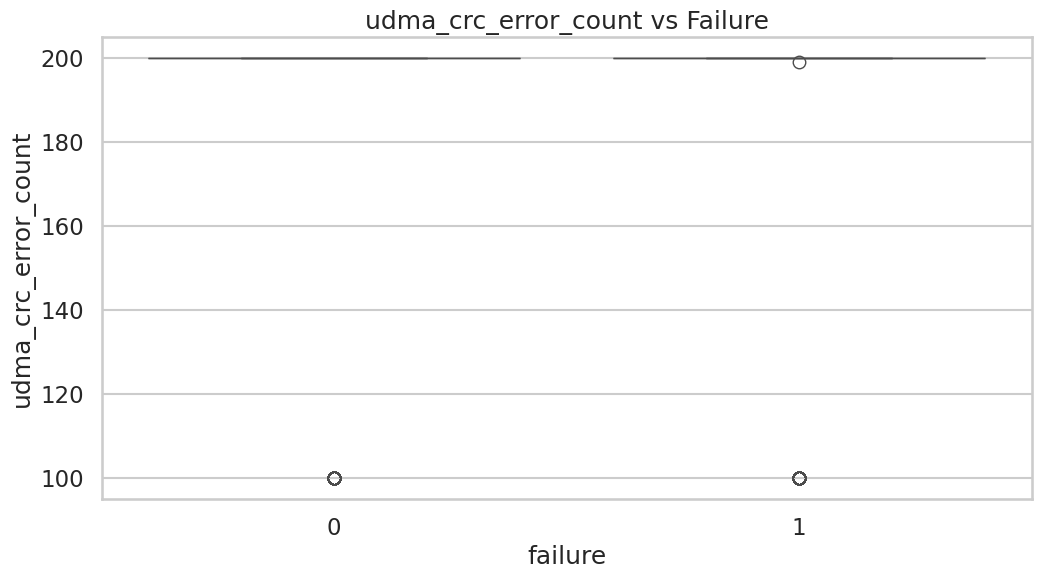

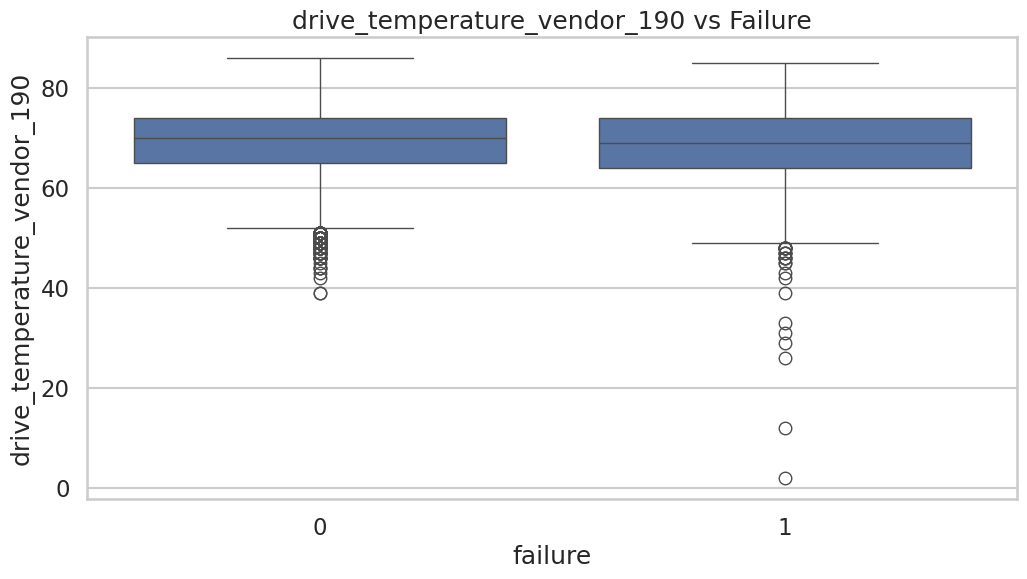

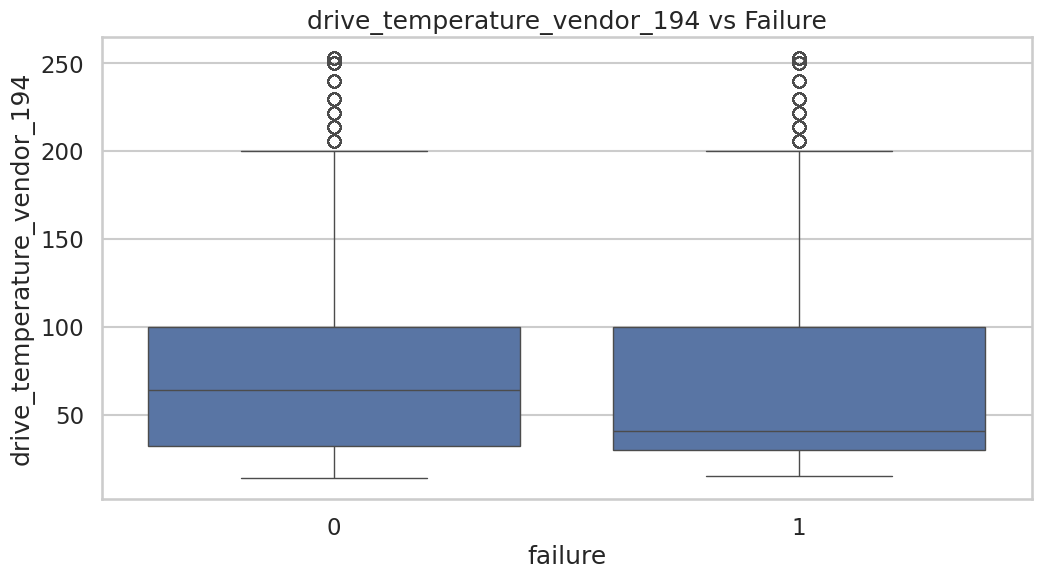

In [19]:
#Outlier separation analysis
for col in features:
    plt.figure()
    sns.boxplot(x="failure", y=col, data=df)
    plt.title(f"{col} vs Failure")
    plt.show()

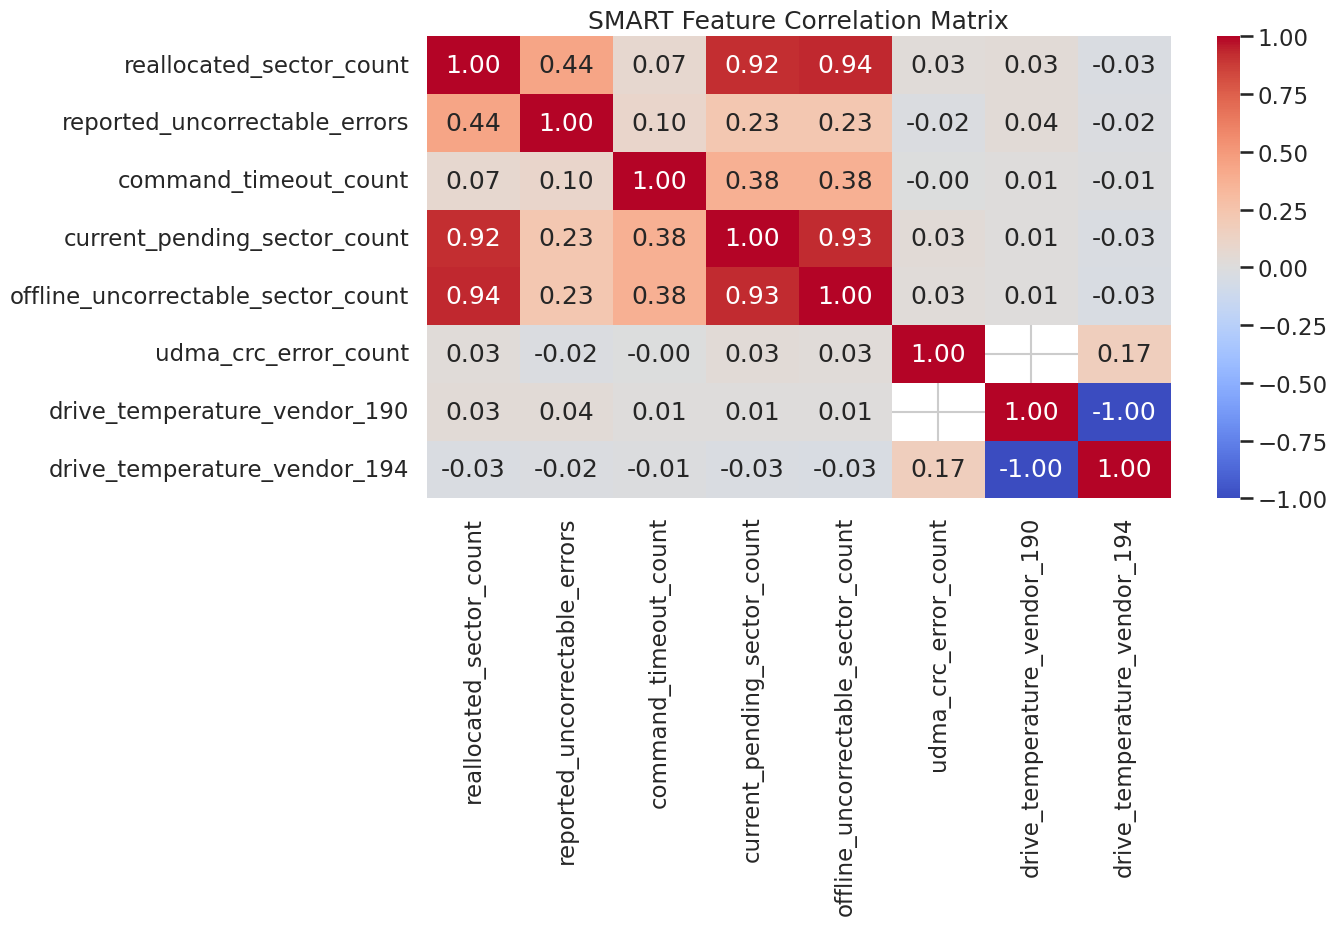

In [20]:
#Multicolinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor
corr = df[features].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("SMART Feature Correlation Matrix")
plt.show()


In [21]:
#Normality Hypothesis check

for col in features:
    stat, p = stats.shapiro(df[col].sample(5000, random_state=42))
    print(f"{col}: Shapiro p-value = {p:.4e}")


reallocated_sector_count: Shapiro p-value = nan
reported_uncorrectable_errors: Shapiro p-value = nan
command_timeout_count: Shapiro p-value = nan
current_pending_sector_count: Shapiro p-value = nan
offline_uncorrectable_sector_count: Shapiro p-value = nan
udma_crc_error_count: Shapiro p-value = nan
drive_temperature_vendor_190: Shapiro p-value = nan
drive_temperature_vendor_194: Shapiro p-value = nan


In [22]:
#Mann Whitney Utest

results = []

for col in features:
    f0 = df[df.failure == 0][col]
    f1 = df[df.failure == 1][col]

    stat, p = stats.mannwhitneyu(f0, f1, alternative="two-sided")

    results.append({
        "feature": col,
        "p_value": p,
        "median_non_failure": f0.median(),
        "median_failure": f1.median()
    })

mw_results = pd.DataFrame(results).sort_values("p_value")
mw_results


feature  p_value  median_non_failure  \
0            reallocated_sector_count      NaN            100.0000   
1       reported_uncorrectable_errors      NaN            100.0000   
2               command_timeout_count      NaN            100.0000   
3        current_pending_sector_count      NaN            100.0000   
4  offline_uncorrectable_sector_count      NaN            100.0000   
5                udma_crc_error_count      NaN            200.0000   
6        drive_temperature_vendor_190      NaN             70.0000   
7        drive_temperature_vendor_194      NaN             64.0000   

   median_failure  
0        100.0000  
1         71.0000  
2        100.0000  
3        100.0000  
4        100.0000  
5        200.0000  
6         69.0000  
7         41.0000

In [23]:
#EFfect Size Practical Significance Test

def cliffs_delta(x, y):
    nx = len(x)
    ny = len(y)
    return (np.sum(x[:, None] > y) - np.sum(x[:, None] < y)) / (nx * ny)

effect_sizes = []

for col in features:
    x = df[df.failure == 1][col].values[:5000]
    y = df[df.failure == 0][col].values[:5000]
    delta = cliffs_delta(x, y)
    effect_sizes.append((col, delta))

pd.DataFrame(effect_sizes, columns=["feature", "cliffs_delta"]).sort_values(
    "cliffs_delta", ascending=False
)


feature  cliffs_delta
5                udma_crc_error_count        0.0067
2               command_timeout_count       -0.0072
6        drive_temperature_vendor_190       -0.0187
4  offline_uncorrectable_sector_count       -0.0594
3        current_pending_sector_count       -0.0633
7        drive_temperature_vendor_194       -0.1229
0            reallocated_sector_count       -0.1741
1       reported_uncorrectable_errors       -0.2444

/tmp/ipython-input-541599134.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk = df.groupby("bin")["failure"].mean()


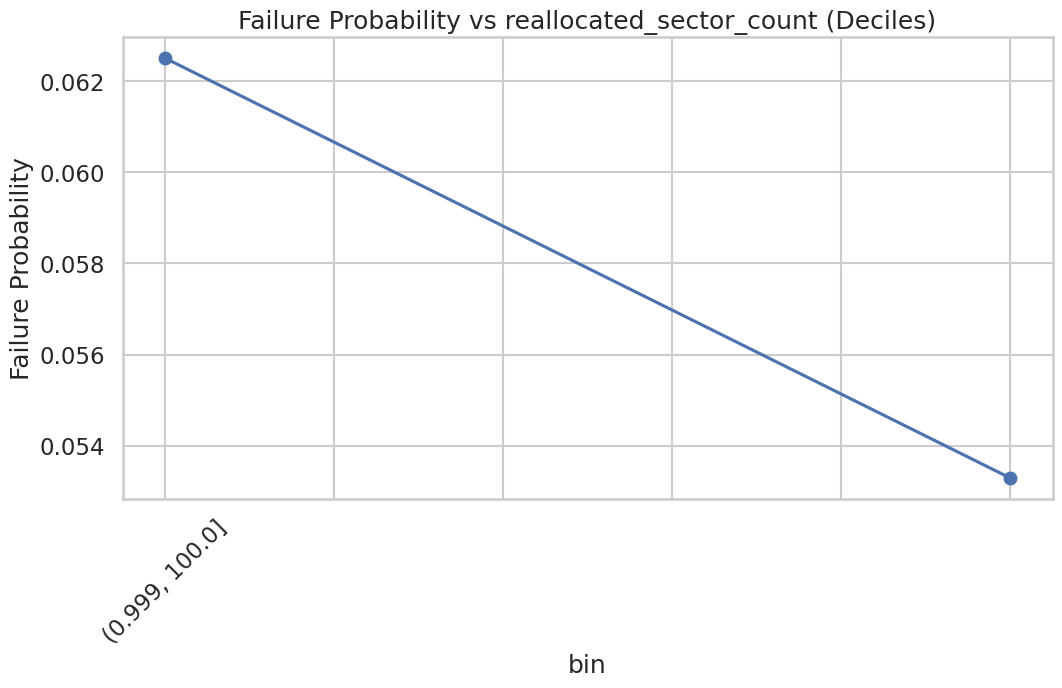

/tmp/ipython-input-541599134.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk = df.groupby("bin")["failure"].mean()


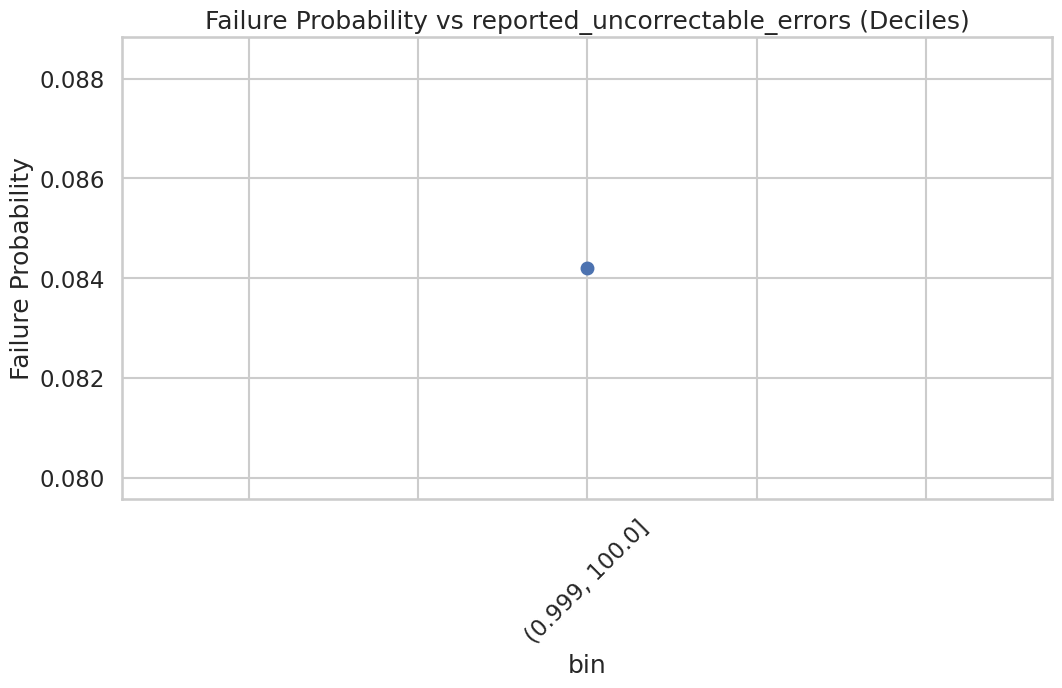

/tmp/ipython-input-541599134.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk = df.groupby("bin")["failure"].mean()


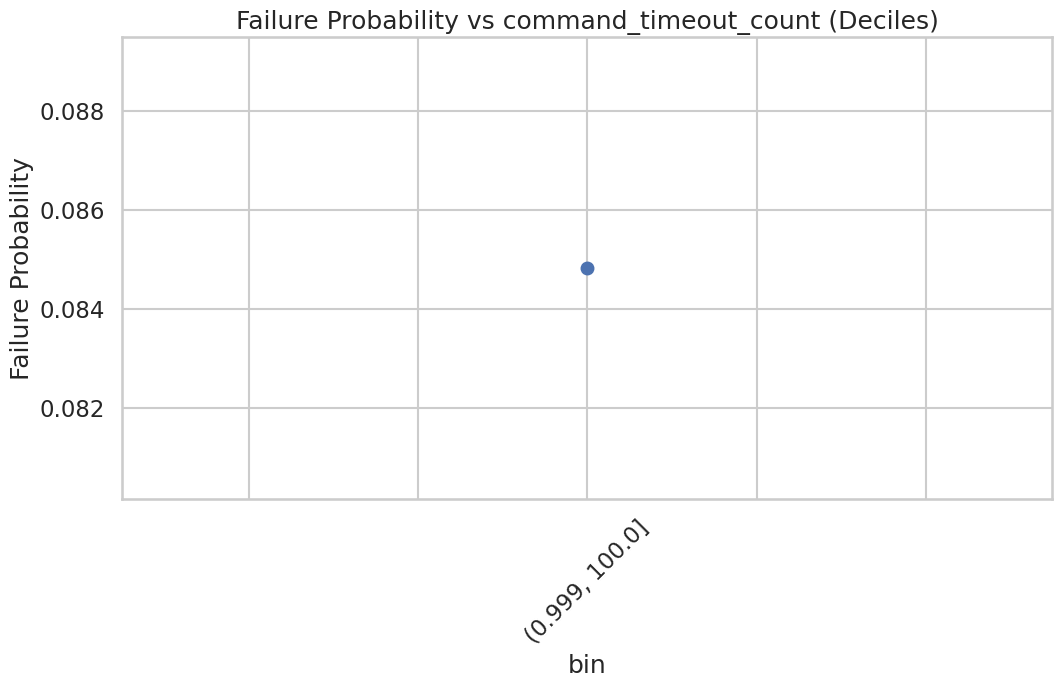

/tmp/ipython-input-541599134.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk = df.groupby("bin")["failure"].mean()


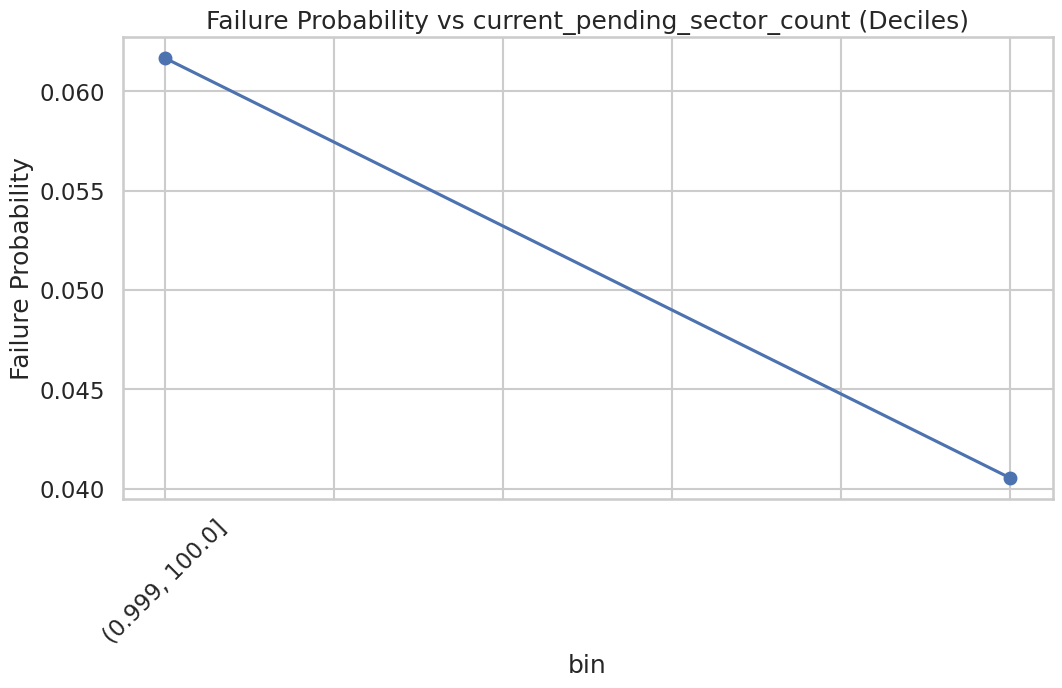

/tmp/ipython-input-541599134.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk = df.groupby("bin")["failure"].mean()


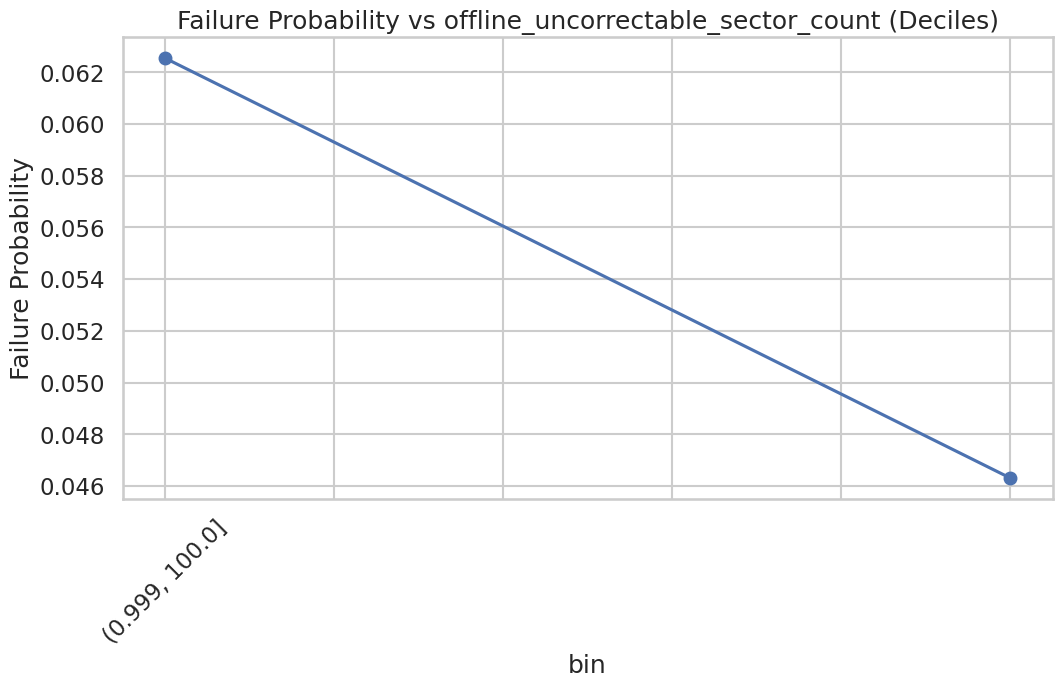

/tmp/ipython-input-541599134.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk = df.groupby("bin")["failure"].mean()


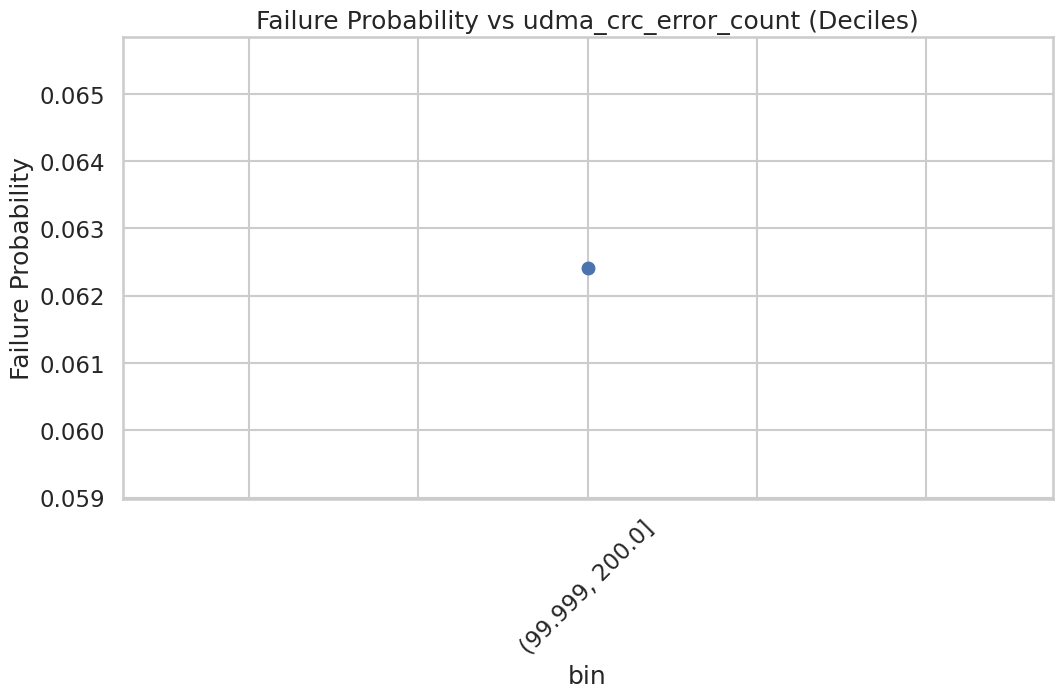

/tmp/ipython-input-541599134.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk = df.groupby("bin")["failure"].mean()


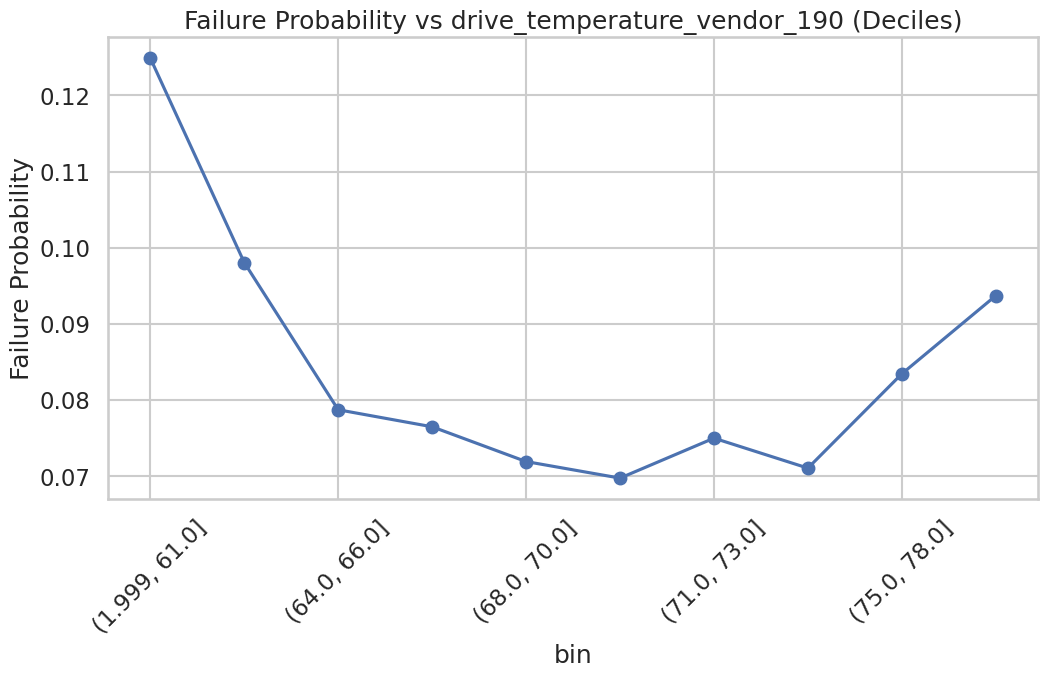

/tmp/ipython-input-541599134.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk = df.groupby("bin")["failure"].mean()


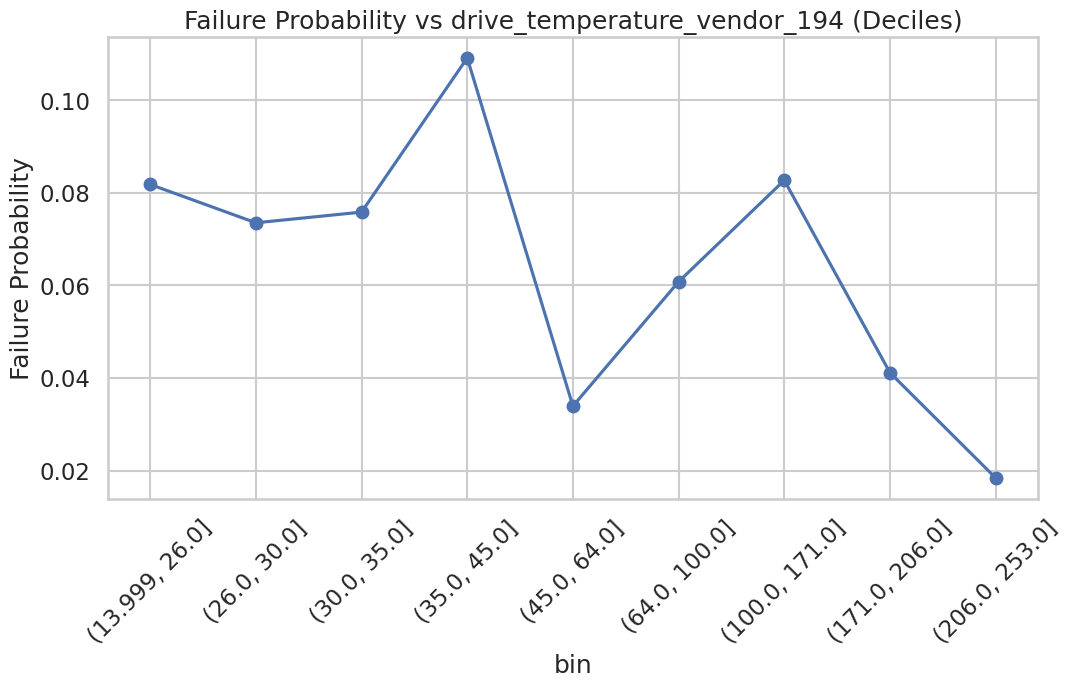

In [24]:
#Risk Stratification Analysis
#Failure Probability Across Feature Deciles

for col in features:
    df["bin"] = pd.qcut(df[col], q=10, duplicates="drop")
    risk = df.groupby("bin")["failure"].mean()

    risk.plot(marker="o")
    plt.title(f"Failure Probability vs {col} (Deciles)")
    plt.ylabel("Failure Probability")
    plt.xticks(rotation=45)
    plt.show()


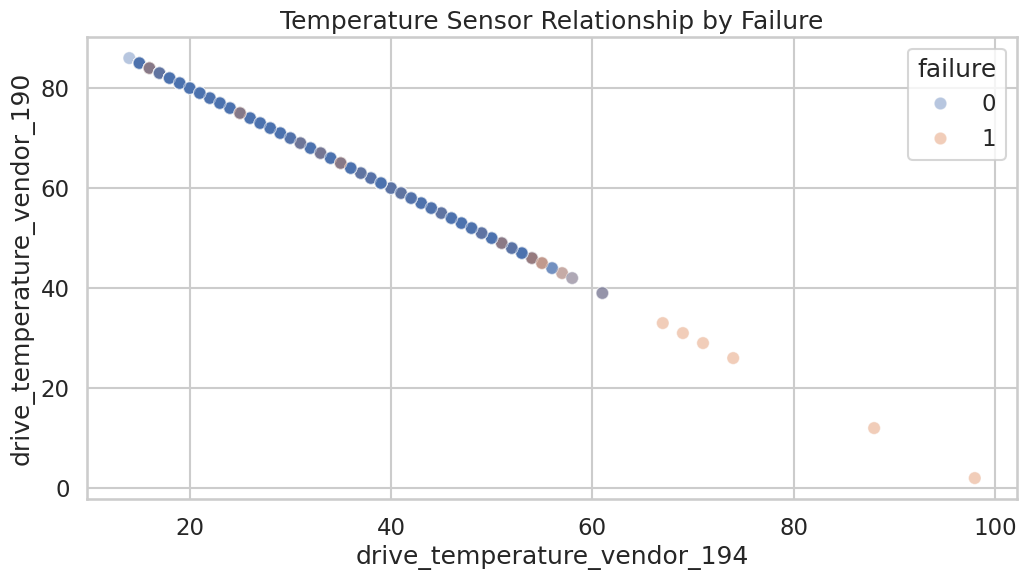

In [25]:
#Temperature Stability Analysis

sns.scatterplot(
    x="drive_temperature_vendor_194",
    y="drive_temperature_vendor_190",
    hue="failure",
    data=df,
    alpha=0.4
)
plt.title("Temperature Sensor Relationship by Failure")
plt.show()


In [26]:
#Feature Sanity Check

scaler = StandardScaler()
scaled = scaler.fit_transform(df[features])

pd.DataFrame(scaled, columns=features).describe()


reallocated_sector_count  reported_uncorrectable_errors  \
count               256724.0000                    106336.0000   
mean                     0.0000                        -0.0000   
std                      1.0000                         1.0000   
min                     -6.5755                        -5.3976   
25%                     -0.0819                         0.2309   
50%                     -0.0819                         0.2309   
75%                     -0.0819                         0.2309   
max                      9.8882                         0.2309   

       command_timeout_count  current_pending_sector_count  \
count            105505.0000                   253662.0000   
mean                 -0.0000                        0.0000   
std                   1.0000                        1.0000   
min                 -55.8567                       -6.9292   
25%                   0.0245                       -0.0885   
50%                   0.0245                       -0.0885   
75%                   0.0245                       -0.0885   
max                   0.0245                       10.4145   

       offline_uncorrectable_sector_count  udma_crc_error_count  \
count                         256622.0000           256724.0000   
mean                               0.0000                0.0000   
std                                1.0000                1.0000   
min                               -6.6730               -2.6339   
25%                               -0.0847                0.3797   
50%                               -0.0847                0.3797   
75%                               -0.0847                0.3797   
max                               10.0306                0.3797   

       drive_temperature_vendor_190  drive_temperature_vendor_194  
count                   105360.0000                   258799.0000  
mean                        -0.0000                       -0.0000  
std                          1.0000                        1.0000  
min                        -10.6365                       -1.0945  
25%                         -0.7027                       -0.8399  
50%                          0.0857                       -0.3872  
75%                          0.7165                        0.1221  
max                          2.6086                        2.2867

In [27]:
#Since we found only a couple of strong predictors, we will do Temporal Feature Engineering to turn weak predictors better predictors


df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["serial_number", "date"])

features = [
    "reallocated_sector_count",
    "reported_uncorrectable_errors",
    "command_timeout_count",
    "udma_crc_error_count",
    "drive_temperature_vendor_190",
    "drive_temperature_vendor_194"
]

# Rolling features
for f in features:
    df[f"{f}_7d_mean"] = df.groupby("serial_number")[f].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )

    df[f"{f}_7d_std"] = df.groupby("serial_number")[f].transform(
        lambda x: x.rolling(7, min_periods=1).std()
    )

    df[f"{f}_delta"] = df.groupby("serial_number")[f].diff()


In [28]:
df.head(10)

date     serial_number        model  capacity_bytes  failure  \
198861 2025-05-26  000a43e7dee60010  DELLBOSS VD    480036847616        0   
225400 2025-04-20  0394cd7bc5d00010  DELLBOSS VD    480036847616        0   
190012 2025-01-19  043d3be09f4a0010  DELLBOSS VD    480036847616        0   
33636  2021-12-09  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
2933   2021-12-11  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
31469  2021-12-12  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
52490  2021-12-13  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
10592  2021-12-26  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
58012  2021-12-27  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
13267  2021-12-29  04a81d26aebf0010  DELLBOSS VD    480036847616        0   

        reallocated_sector_count  reported_uncorrectable_errors  \
198861                       NaN                            NaN   
225400                       NaN                            NaN   
190012                       NaN                            NaN   
33636                        NaN                            NaN   
2933                         NaN                            NaN   
31469                        NaN                            NaN   
52490                        NaN                            NaN   
10592                        NaN                            NaN   
58012                        NaN                            NaN   
13267                        NaN                            NaN   

        command_timeout_count  current_pending_sector_count  \
198861                    NaN                           NaN   
225400                    NaN                           NaN   
190012                    NaN                           NaN   
33636                     NaN                           NaN   
2933                      NaN                           NaN   
31469                     NaN                           NaN   
52490                     NaN                           NaN   
10592                     NaN                           NaN   
58012                     NaN                           NaN   
13267                     NaN                           NaN   

        offline_uncorrectable_sector_count  udma_crc_error_count  \
198861                                 NaN                   NaN   
225400                                 NaN                   NaN   
190012                                 NaN                   NaN   
33636                                  NaN                   NaN   
2933                                   NaN                   NaN   
31469                                  NaN                   NaN   
52490                                  NaN                   NaN   
10592                                  NaN                   NaN   
58012                                  NaN                   NaN   
13267                                  NaN                   NaN   

        drive_temperature_vendor_190  drive_temperature_vendor_194  year  bin  \
198861                           NaN                           NaN  2025  NaN   
225400                           NaN                           NaN  2025  NaN   
190012                           NaN                           NaN  2025  NaN   
33636                            NaN                           NaN  2021  NaN   
2933                             NaN                           NaN  2021  NaN   
31469                            NaN                           NaN  2021  NaN   
52490                            NaN                           NaN  2021  NaN   
10592                            NaN                           NaN  2021  NaN   
58012                            NaN                           NaN  2021  NaN   
13267                            NaN                           NaN  2021  NaN   

        reallocated_sector_count_7d_mean  reallocated_sector_count_7d_std  \
198861         

In [29]:
for f in features:
    df[f"{f}_cumulative"] = df.groupby("serial_number")[f].cumsum()


In [30]:
df.head(5)

date     serial_number        model  capacity_bytes  failure  \
198861 2025-05-26  000a43e7dee60010  DELLBOSS VD    480036847616        0   
225400 2025-04-20  0394cd7bc5d00010  DELLBOSS VD    480036847616        0   
190012 2025-01-19  043d3be09f4a0010  DELLBOSS VD    480036847616        0   
33636  2021-12-09  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
2933   2021-12-11  04a81d26aebf0010  DELLBOSS VD    480036847616        0   

        reallocated_sector_count  reported_uncorrectable_errors  \
198861                       NaN                            NaN   
225400                       NaN                            NaN   
190012                       NaN                            NaN   
33636                        NaN                            NaN   
2933                         NaN                            NaN   

        command_timeout_count  current_pending_sector_count  \
198861                    NaN                           NaN   
225400                    NaN                           NaN   
190012                    NaN                           NaN   
33636                     NaN                           NaN   
2933                      NaN                           NaN   

        offline_uncorrectable_sector_count  udma_crc_error_count  \
198861                                 NaN                   NaN   
225400                                 NaN                   NaN   
190012                                 NaN                   NaN   
33636                                  NaN                   NaN   
2933                                   NaN                   NaN   

        drive_temperature_vendor_190  drive_temperature_vendor_194  year  bin  \
198861                           NaN                           NaN  2025  NaN   
225400                           NaN                           NaN  2025  NaN   
190012                           NaN                           NaN  2025  NaN   
33636                            NaN                           NaN  2021  NaN   
2933                             NaN                           NaN  2021  NaN   

        reallocated_sector_count_7d_mean  reallocated_sector_count_7d_std  \
198861                               NaN                              NaN   
225400                               NaN                              NaN   
190012                               NaN                              NaN   
33636                                NaN                              NaN   
2933                                 NaN                              NaN   

        reallocated_sector_count_delta  reported_uncorrectable_errors_7d_mean  \
198861                             NaN                                    NaN   
225400                             NaN                                    NaN   
190012                             NaN                                    NaN   
33636                              NaN                                    NaN   
2933                               NaN                                    NaN   

        reported_uncorrectable_errors_7d_std  \
198861                                   NaN   
225400                                   NaN   
190012                                   NaN   
33636                                    NaN   
2933                                     NaN   

        reported_uncorrectable_errors_delta  command_timeout_count_7d_mean  \
198861                                  NaN                            NaN   
225400                                  NaN                            NaN   
190012                                  NaN                            NaN   
33636                                   NaN                            NaN   
2933                                    NaN                            NaN   

        command_timeout_count_7d_std  command_timeout_count_delta  \
198861                           NaN                          NaN   
225400                    

In [31]:
thresholds = {
    "command_timeout_count": 1,
    "udma_crc_error_count": 1,
    "reported_uncorrectable_errors": 1
}

for f, t in thresholds.items():
    df[f"{f}_flag"] = (df[f] > t).astype(int)


In [32]:
df["pending_x_uncorrectable"] = (
    df["current_pending_sector_count"] *
    df["offline_uncorrectable_sector_count"]
)

df["temp_stress"] = (
    df["drive_temperature_vendor_194"] -
    df["drive_temperature_vendor_190"]
)


In [33]:
import numpy as np

for f in features:
    df[f"{f}_log"] = np.log1p(df[f])


In [34]:
df.head(10)

date     serial_number        model  capacity_bytes  failure  \
198861 2025-05-26  000a43e7dee60010  DELLBOSS VD    480036847616        0   
225400 2025-04-20  0394cd7bc5d00010  DELLBOSS VD    480036847616        0   
190012 2025-01-19  043d3be09f4a0010  DELLBOSS VD    480036847616        0   
33636  2021-12-09  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
2933   2021-12-11  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
31469  2021-12-12  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
52490  2021-12-13  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
10592  2021-12-26  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
58012  2021-12-27  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
13267  2021-12-29  04a81d26aebf0010  DELLBOSS VD    480036847616        0   

        reallocated_sector_count  reported_uncorrectable_errors  \
198861                       NaN                            NaN   
225400                       NaN                            NaN   
190012                       NaN                            NaN   
33636                        NaN                            NaN   
2933                         NaN                            NaN   
31469                        NaN                            NaN   
52490                        NaN                            NaN   
10592                        NaN                            NaN   
58012                        NaN                            NaN   
13267                        NaN                            NaN   

        command_timeout_count  current_pending_sector_count  \
198861                    NaN                           NaN   
225400                    NaN                           NaN   
190012                    NaN                           NaN   
33636                     NaN                           NaN   
2933                      NaN                           NaN   
31469                     NaN                           NaN   
52490                     NaN                           NaN   
10592                     NaN                           NaN   
58012                     NaN                           NaN   
13267                     NaN                           NaN   

        offline_uncorrectable_sector_count  udma_crc_error_count  \
198861                                 NaN                   NaN   
225400                                 NaN                   NaN   
190012                                 NaN                   NaN   
33636                                  NaN                   NaN   
2933                                   NaN                   NaN   
31469                                  NaN                   NaN   
52490                                  NaN                   NaN   
10592                                  NaN                   NaN   
58012                                  NaN                   NaN   
13267                                  NaN                   NaN   

        drive_temperature_vendor_190  drive_temperature_vendor_194  year  bin  \
198861                           NaN                           NaN  2025  NaN   
225400                           NaN                           NaN  2025  NaN   
190012                           NaN                           NaN  2025  NaN   
33636                            NaN                           NaN  2021  NaN   
2933                             NaN                           NaN  2021  NaN   
31469                            NaN                           NaN  2021  NaN   
52490                            NaN                           NaN  2021  NaN   
10592                            NaN                           NaN  2021  NaN   
58012                            NaN                           NaN  2021  NaN   
13267                            NaN                           NaN  2021  NaN   

        reallocated_sector_count_7d_mean  reallocated_sector_count_7d_std  \
198861         

In [35]:
df = df.sort_values(["serial_number", "date"])

df = df.groupby("serial_number").apply(
    lambda g: g.ffill()
).reset_index(drop=True)

# Fix: Drop the 'bin' column before filling remaining NaNs with 0,
# as it is a categorical column and 0 is not a valid category.
if 'bin' in df.columns:
    df.drop(columns=['bin'], inplace=True)

# Remaining NaNs (early rows) → 0
df.fillna(0, inplace=True)

/tmp/ipython-input-2369048157.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("serial_number").apply(


In [36]:
df.head(5)


date     serial_number        model  capacity_bytes  failure  \
0 2025-05-26  000a43e7dee60010  DELLBOSS VD    480036847616        0   
1 2025-04-20  0394cd7bc5d00010  DELLBOSS VD    480036847616        0   
2 2025-01-19  043d3be09f4a0010  DELLBOSS VD    480036847616        0   
3 2021-12-09  04a81d26aebf0010  DELLBOSS VD    480036847616        0   
4 2021-12-11  04a81d26aebf0010  DELLBOSS VD    480036847616        0   

   reallocated_sector_count  reported_uncorrectable_errors  \
0                    0.0000                         0.0000   
1                    0.0000                         0.0000   
2                    0.0000                         0.0000   
3                    0.0000                         0.0000   
4                    0.0000                         0.0000   

   command_timeout_count  current_pending_sector_count  \
0                 0.0000                        0.0000   
1                 0.0000                        0.0000   
2                 0.0000                        0.0000   
3                 0.0000                        0.0000   
4                 0.0000                        0.0000   

   offline_uncorrectable_sector_count  udma_crc_error_count  \
0                              0.0000                0.0000   
1                              0.0000                0.0000   
2                              0.0000                0.0000   
3                              0.0000                0.0000   
4                              0.0000                0.0000   

   drive_temperature_vendor_190  drive_temperature_vendor_194  year  \
0                        0.0000                        0.0000  2025   
1                        0.0000                        0.0000  2025   
2                        0.0000                        0.0000  2025   
3                        0.0000                        0.0000  2021   
4                        0.0000                        0.0000  2021   

   reallocated_sector_count_7d_mean  reallocated_sector_count_7d_std  \
0                            0.0000                           0.0000   
1                            0.0000                           0.0000   
2                            0.0000                           0.0000   
3                            0.0000                           0.0000   
4                            0.0000                           0.0000   

   reallocated_sector_count_delta  reported_uncorrectable_errors_7d_mean  \
0                          0.0000                                 0.0000   
1                          0.0000                                 0.0000   
2                          0.0000                                 0.0000   
3                          0.0000                                 0.0000   
4                          0.0000                                 0.0000   

   reported_uncorrectable_errors_7d_std  reported_uncorrectable_errors_delta  \
0                                0.0000                               0.0000   
1                                0.0000                               0.0000   
2                                0.0000                               0.0000   
3                                0.0000                               0.0000   
4                                0.0000                               0.0000   

   command_timeout_count_7d_mean  command_timeout_count_7d_std  \
0                         0.0000                        0.0000   
1                         0.0000                        0.0000   
2                         0.0000                        0.0000   
3                         0.0000                        0.0000   
4                         0.0000                        0.0000   

   command_timeout_count_delta  udma_crc_error_count_7d_mean  \
0                       0.0000                        0.0000   
1                       0.0000                        0.0000   
2                       0.0000                        0.0000   
3                      

In [37]:
# Identify numerical columns that are not identifiers or target
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
exclude_cols = ['failure', 'capacity_bytes', 'year'] # Exclude target and metadata
numerical_feature_cols = [col for col in numerical_cols if col not in exclude_cols]

# Filter for rows where at least one numerical feature is non-zero
non_zero_records = df[ (df[numerical_feature_cols] != 0).any(axis=1) ]

# Display the first 100 non-zero records
display(non_zero_records.head(100))

date serial_number                 model  capacity_bytes  failure  \
25  2025-02-28  1030A00KF9RG  TOSHIBA MG07ACA14TEY  14000519643136        0   
26  2024-08-02  1030A00MF9RG  TOSHIBA MG07ACA14TEY  14000519643136        0   
27  2024-08-08  1030A00MF9RG  TOSHIBA MG07ACA14TEY  14000519643136        0   
28  2021-12-18  1030A00UF97G   TOSHIBA MG07ACA14TA  14000519643136        0   
29  2021-12-20  1030A00UF97G   TOSHIBA MG07ACA14TA  14000519643136        0   
..         ...           ...                   ...             ...      ...   
120 2024-08-16  1040A07XF97G   TOSHIBA MG07ACA14TA  14000519643136        0   
121 2024-08-07  1040A085F97G   TOSHIBA MG07ACA14TA  14000519643136        0   
122 2021-08-21  1040A087F97G   TOSHIBA MG07ACA14TA  14000519643136        0   
123 2021-08-04  1040A088F97G   TOSHIBA MG07ACA14TA  14000519643136        0   
124 2022-12-31  1040A08AF97G   TOSHIBA MG07ACA14TA  14000519643136        0   

     reallocated_sector_count  reported_uncorrectable_errors  \
25                   100.0000                         0.0000   
26                   100.0000                         0.0000   
27                   100.0000                         0.0000   
28                   100.0000                         0.0000   
29                   100.0000                         0.0000   
..                        ...                            ...   
120                  100.0000                         0.0000   
121                  100.0000                         0.0000   
122                  100.0000                         0.0000   
123                  100.0000                         0.0000   
124                  100.0000                         0.0000   

     command_timeout_count  current_pending_sector_count  \
25                  0.0000                        0.0000   
26                  0.0000                        0.0000   
27                  0.0000                        0.0000   
28                  0.0000                      100.0000   
29                  0.0000                      100.0000   
..                     ...                           ...   
120                 0.0000                      100.0000   
121                 0.0000                      100.0000   
122                 0.0000                      100.0000   
123                 0.0000                      100.0000   
124                 0.0000                      100.0000   

     offline_uncorrectable_sector_count  udma_crc_error_count  \
25                             100.0000              200.0000   
26                             100.0000              200.0000   
27                             100.0000              200.0000   
28                             100.0000              200.0000   
29                             100.0000              200.0000   
..                                  ...                   ...   
120                            100.0000              200.0000   
121                            100.0000              200.0000   
122                            100.0000              200.0000   
123                            100.0000              200.0000   
124                            100.0000              200.0000   

     drive_temperature_vendor_190  drive_temperature_vendor_194  year  \
25                         0.0000                      100.0000  2025   
26                         0.0000                      100.0000  2024   
27                         0.0000                      100.0000  2024   
28                         0.0000                      100.0000  2021   
29                         0.0000                      100.0000  2021   
..                            ...                           ...   ...   
120                        0.0000                      100.0000  2024   
121                        0.0000                      100.0000  2024   
122                        0.0000                      100.0000  2021   
123                        0.0000                      100.0

In [38]:
df["cold_start"] = (
    df.groupby("serial_number").cumcount() < 7
).astype(int)


In [39]:
df.isna().mean().sort_values(ascending=False).head(15)


date                                 0.0000
serial_number                        0.0000
model                                0.0000
capacity_bytes                       0.0000
failure                              0.0000
reallocated_sector_count             0.0000
reported_uncorrectable_errors        0.0000
command_timeout_count                0.0000
current_pending_sector_count         0.0000
offline_uncorrectable_sector_count   0.0000
udma_crc_error_count                 0.0000
drive_temperature_vendor_190         0.0000
drive_temperature_vendor_194         0.0000
year                                 0.0000
reallocated_sector_count_7d_mean     0.0000
dtype: float64

In [40]:
#Second Pass EDA

print("Shape:", df.shape)
print("Failure rate:", df.failure.mean())
df.describe(include="number").T.head(15)


Shape: (259151, 50)
Failure rate: 0.06250024117213517


count                mean  \
capacity_bytes                        259151.0000 11366152920726.4902   
failure                               259151.0000              0.0625   
reallocated_sector_count              259151.0000            100.3094   
reported_uncorrectable_errors         259151.0000             39.3720   
command_timeout_count                 259151.0000             40.7003   
current_pending_sector_count          259151.0000             99.1444   
offline_uncorrectable_sector_count    259151.0000            100.2945   
udma_crc_error_count                  259151.0000            185.6659   
drive_temperature_vendor_190          259151.0000             28.2422   
drive_temperature_vendor_194          259151.0000             91.2512   
year                                  259151.0000           2023.1303   
reallocated_sector_count_7d_mean      259151.0000            100.3395   
reallocated_sector_count_7d_std       259151.0000              0.0347   
reallocated_sector_count_delta        259151.0000             -0.0526   
reported_uncorrectable_errors_7d_mean 259151.0000             39.5830   

                                                     std       min  \
capacity_bytes                        4858931152878.9971   -1.0000   
failure                                           0.2421    0.0000   
reallocated_sector_count                         18.0108    0.0000   
reported_uncorrectable_errors                    48.5191    0.0000   
command_timeout_count                            49.1226    0.0000   
current_pending_sector_count                     20.4147    0.0000   
offline_uncorrectable_sector_count               17.9372    0.0000   
udma_crc_error_count                             37.5942    0.0000   
drive_temperature_vendor_190                     34.3559    0.0000   
drive_temperature_vendor_194                     70.7158    0.0000   
year                                              1.6211 2020.0000   
reallocated_sector_count_7d_mean                 17.9455    0.0000   
reallocated_sector_count_7d_std                   1.0811    0.0000   
reallocated_sector_count_delta                    1.6555  -99.0000   
reported_uncorrectable_errors_7d_mean            48.5183    0.0000   

                                                     25%                 50%  \
capacity_bytes                        8001563222016.0000 12000138625024.0000   
failure                                           0.0000              0.0000   
reallocated_sector_count                        100.0000            100.0000   
reported_uncorrectable_errors                     0.0000              0.0000   
command_timeout_count                             0.0000              0.0000   
current_pending_sector_count                    100.0000            100.0000   
offline_uncorrectable_sector_count              100.0000            100.0000   
udma_crc_error_count                            200.0000            200.0000   
drive_temperature_vendor_190                      0.0000              0.0000   
drive_temperature_vendor_194                     32.0000             64.0000   
year                                           2022.0000           2023.0000   
reallocated_sector_count_7d_mean                100.0000            100.0000   
reallocated_sector_count_7d_std                   0.0000              0.0000   
reallocated_sector_count_delta                    0.0000              0.0000   
reported_uncorrectable_errors_7d_mean             0.0000              0.0000   

                                                      75%                 max  
capacity_bytes                        14000519643136.0000 24000277250048.0000  
failure                                            0.0000              1.0000  
reallocated_sector_count                         100.0000            252.0000  
reported_uncorrectable_errors                    100.0000            100.0000  
command_timeout_count                            100.0000            100.

In [41]:
#Define Feature Group

raw_features = [
    "reallocated_sector_count",
    "reported_uncorrectable_errors",
    "command_timeout_count",
    "current_pending_sector_count",
    "offline_uncorrectable_sector_count",
    "udma_crc_error_count",
    "drive_temperature_vendor_190",
    "drive_temperature_vendor_194"
]

engineered_features = [
    c for c in df.columns
    if any(s in c for s in ["_7d_", "_delta", "_cumulative", "_flag", "_log"])
]


In [42]:
summary = (
    df.groupby("failure")[engineered_features]
    .mean()
    .T
)

summary.columns = ["non_failure_mean", "failure_mean"]

summary["mean_diff"] = summary["failure_mean"] - summary["non_failure_mean"]

summary.sort_values("mean_diff", ascending=False).head(20)


non_failure_mean  failure_mean  \
command_timeout_count_7d_mean                  39.7421       55.1335   
drive_temperature_vendor_190_7d_mean           27.6247       37.9938   
udma_crc_error_count_7d_mean                  185.2260      192.2639   
reported_uncorrectable_errors_7d_std            0.0218        3.7588   
command_timeout_count_log                       1.8341        2.5465   
drive_temperature_vendor_190_log                1.6876        2.3408   
reallocated_sector_count_7d_std                 0.0015        0.5321   
command_timeout_count_flag                      0.3974        0.5508   
drive_temperature_vendor_190_7d_std             0.2079        0.2941   
command_timeout_count_7d_std                    0.0000        0.0696   
udma_crc_error_count_log                        5.1653        5.2122   
reported_uncorrectable_errors_flag              0.4002        0.4004   
udma_crc_error_count_delta                      0.0000        0.0000   
udma_crc_error_count_7d_std                     0.0000        0.0000   
udma_crc_error_count_flag                       0.9907        0.9893   
reported_uncorrectable_errors_log               1.8455        1.8163   
drive_temperature_vendor_190_delta             -0.0435       -0.1067   
reallocated_sector_count_log                    4.5812        4.5075   
command_timeout_count_delta                     0.0000       -0.1067   
drive_temperature_vendor_194_7d_std             1.2519        1.1222   

                                      mean_diff  
command_timeout_count_7d_mean           15.3914  
drive_temperature_vendor_190_7d_mean    10.3691  
udma_crc_error_count_7d_mean             7.0379  
reported_uncorrectable_errors_7d_std     3.7370  
command_timeout_count_log                0.7124  
drive_temperature_vendor_190_log         0.6532  
reallocated_sector_count_7d_std          0.5306  
command_timeout_count_flag               0.1534  
drive_temperature_vendor_190_7d_std      0.0862  
command_timeout_count_7d_std             0.0696  
udma_crc_error_count_log                 0.0469  
reported_uncorrectable_errors_flag       0.0003  
udma_crc_error_count_delta               0.0000  
udma_crc_error_count_7d_std              0.0000  
udma_crc_error_count_flag               -0.0014  
reported_uncorrectable_errors_log       -0.0292  
drive_temperature_vendor_190_delta      -0.0632  
reallocated_sector_count_log            -0.0737  
command_timeout_count_delta             -0.1067  
drive_temperature_vendor_194_7d_std     -0.1296

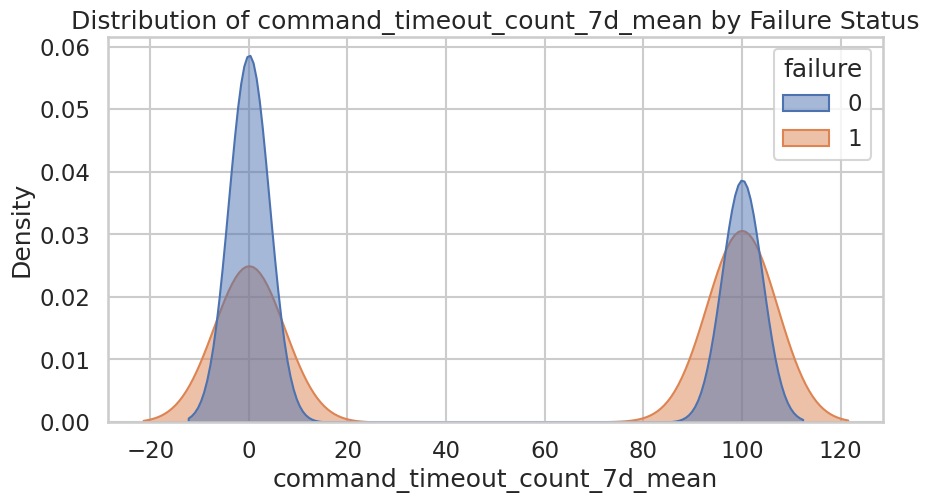

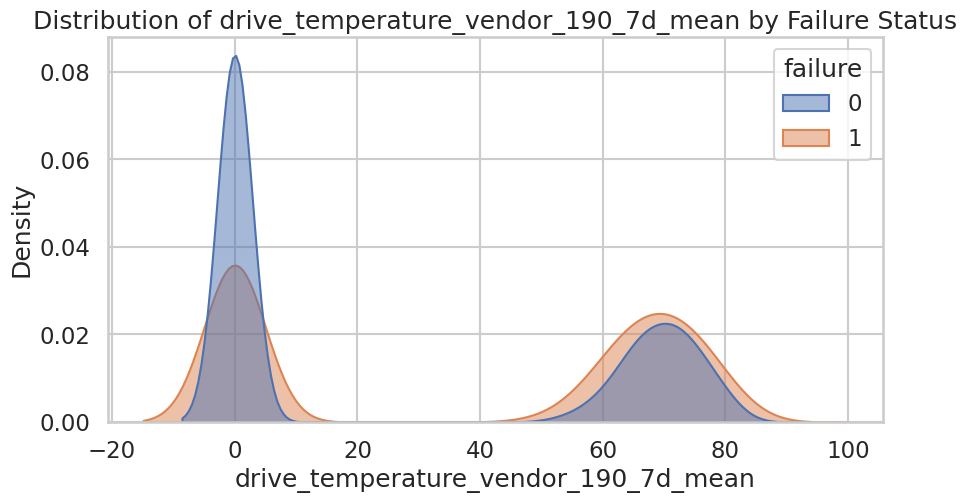

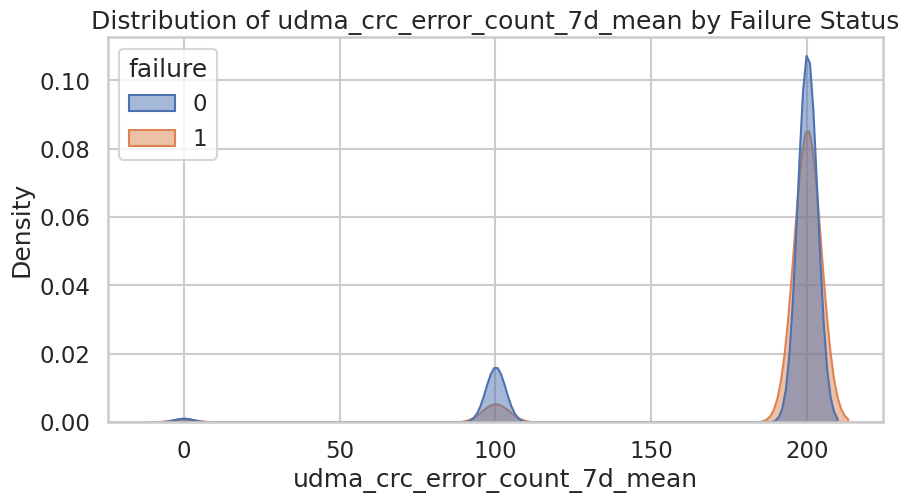

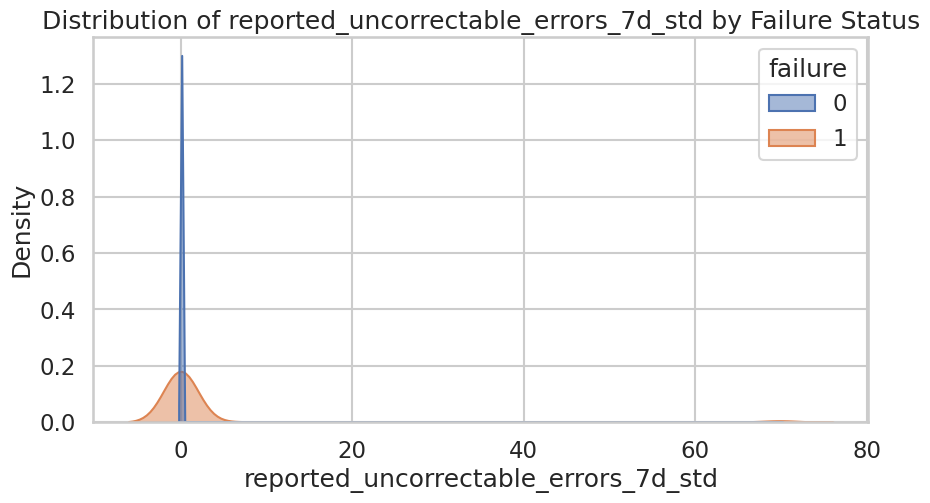

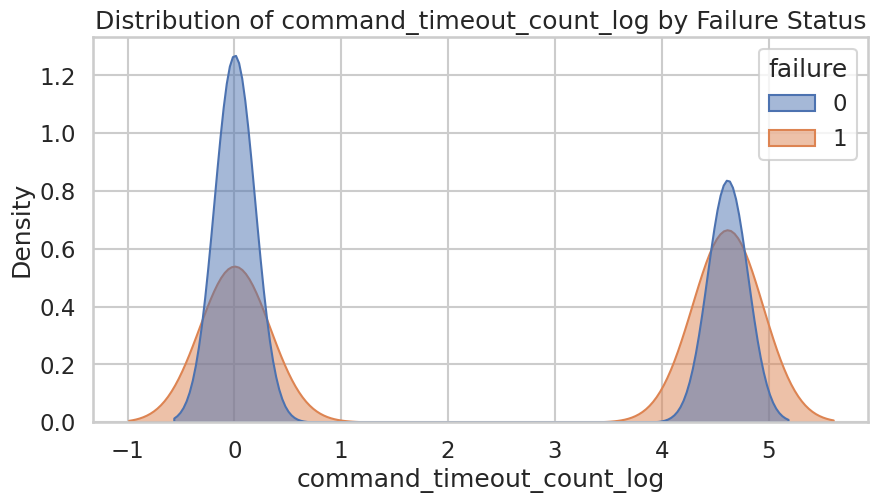

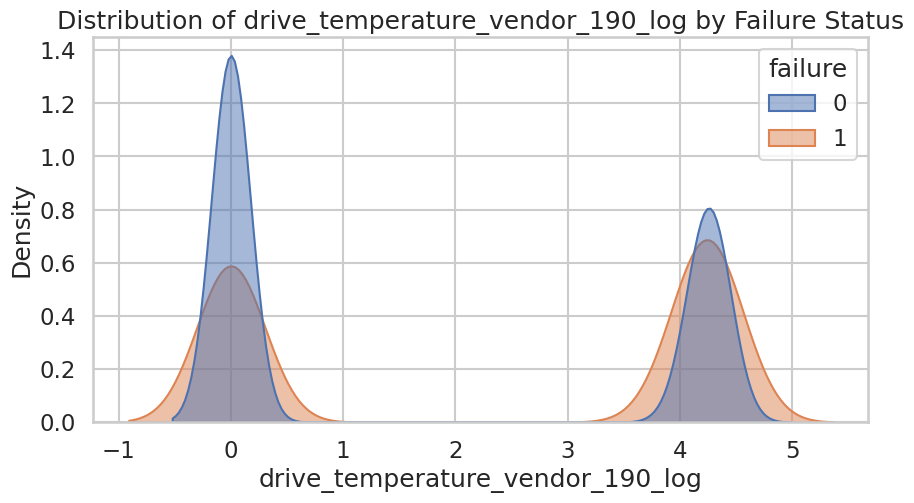

In [43]:
#Visual EDA
top_features = (
    summary.sort_values("mean_diff", ascending=False)
    .head(6)
    .index
    .tolist()
)

top_features

import seaborn as sns
import matplotlib.pyplot as plt

for f in top_features:
    plt.figure(figsize=(10,5))
    sns.kdeplot(
        data=df, x=f, hue="failure",
        common_norm=False, fill=True, alpha=0.5
    )
    plt.title(f"Distribution of {f} by Failure Status")
    plt.show()


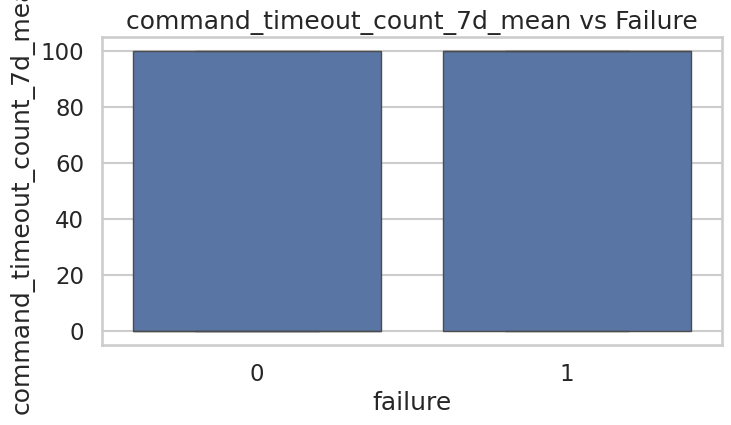

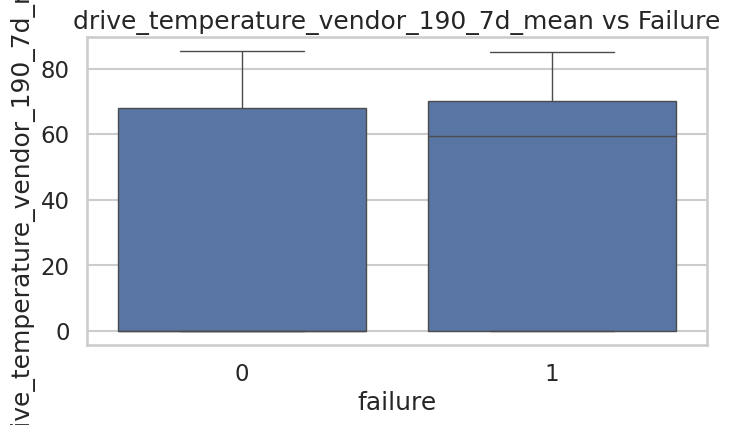

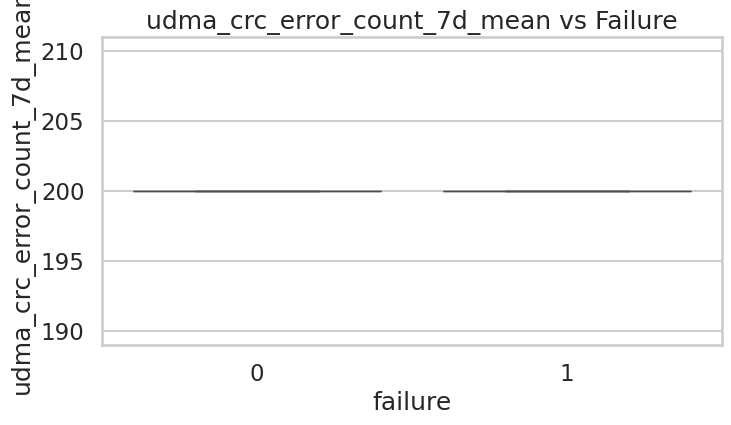

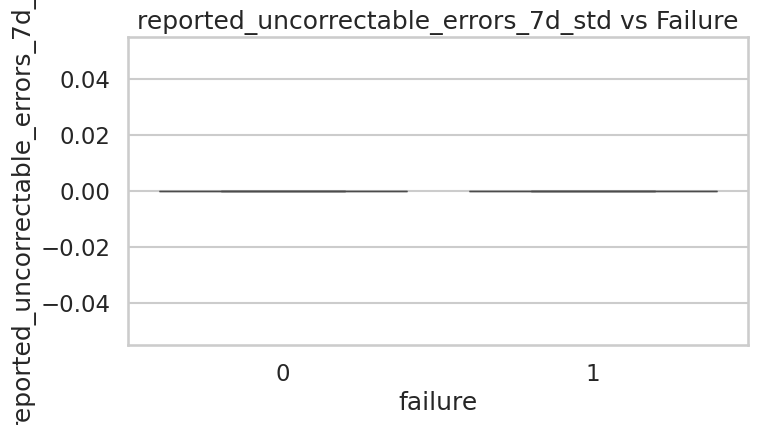

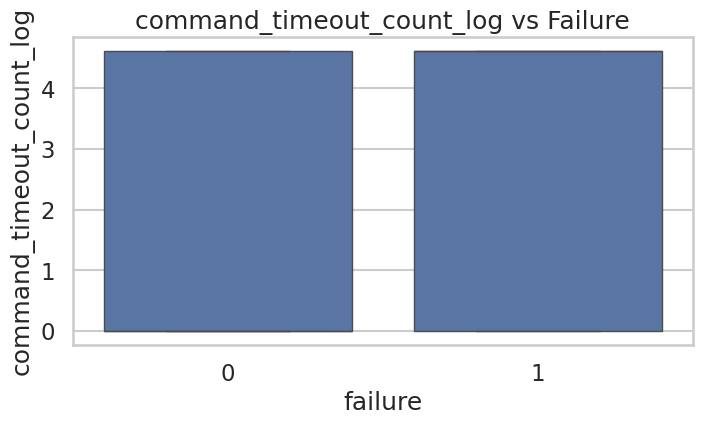

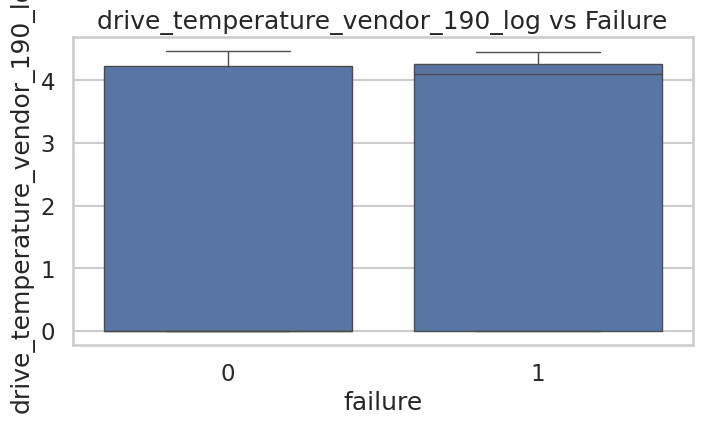

In [44]:
for f in top_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x="failure", y=f, data=df, showfliers=False)
    plt.title(f"{f} vs Failure")
    plt.show()


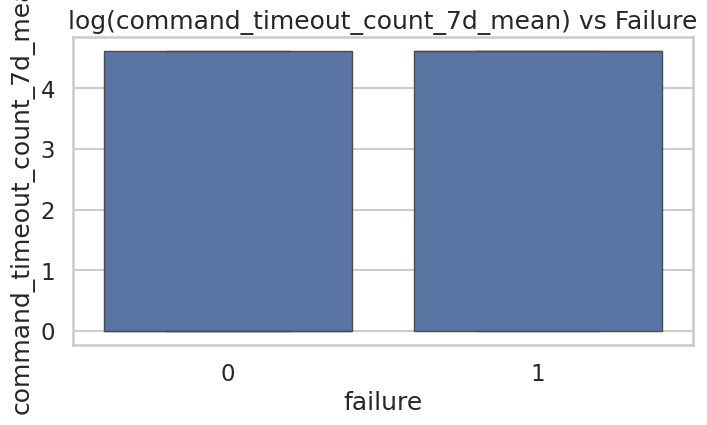

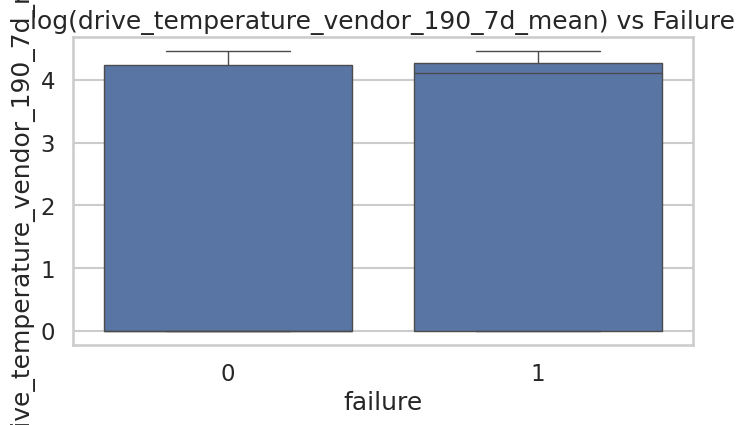

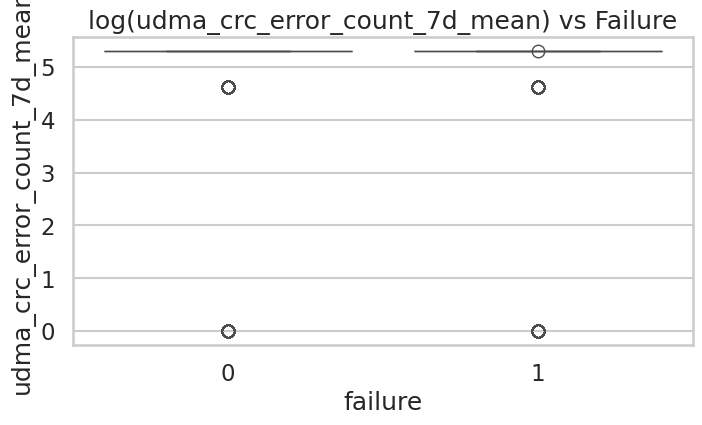

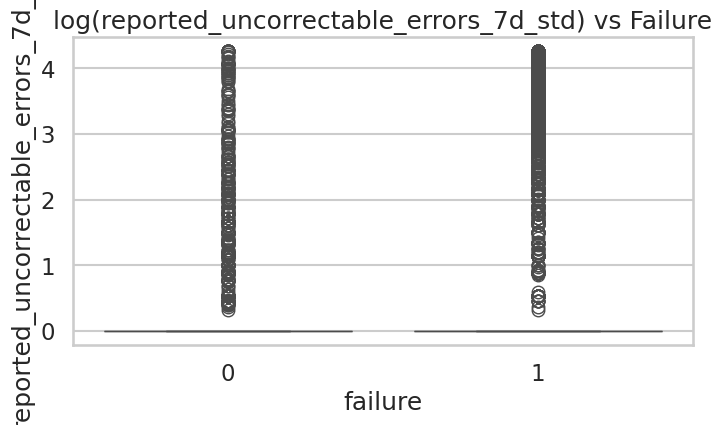

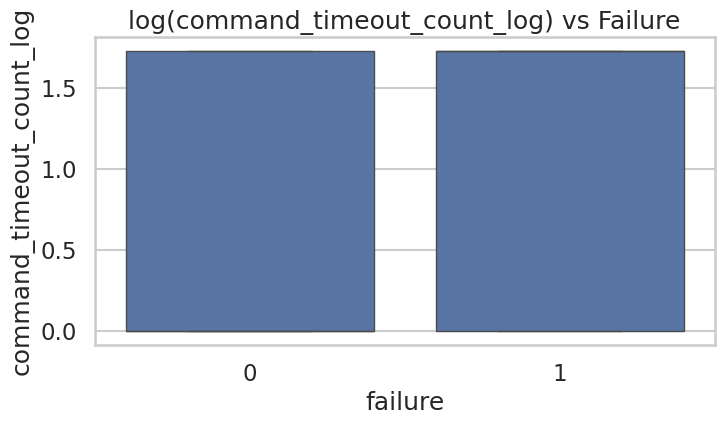

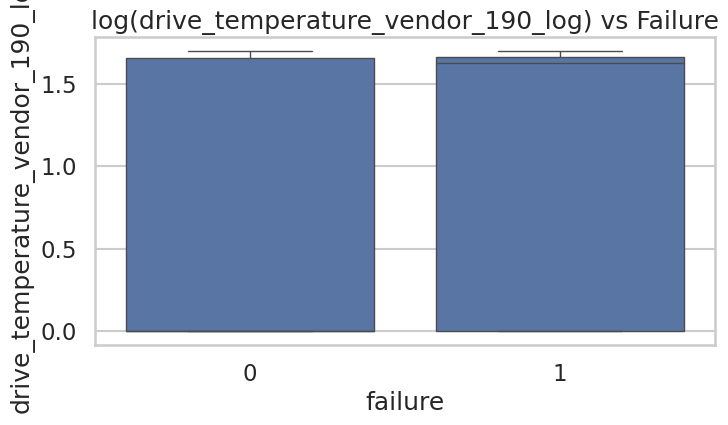

In [45]:
for f in top_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x="failure", y=np.log1p(df[f]), data=df)
    plt.title(f"log({f}) vs Failure")
    plt.show()



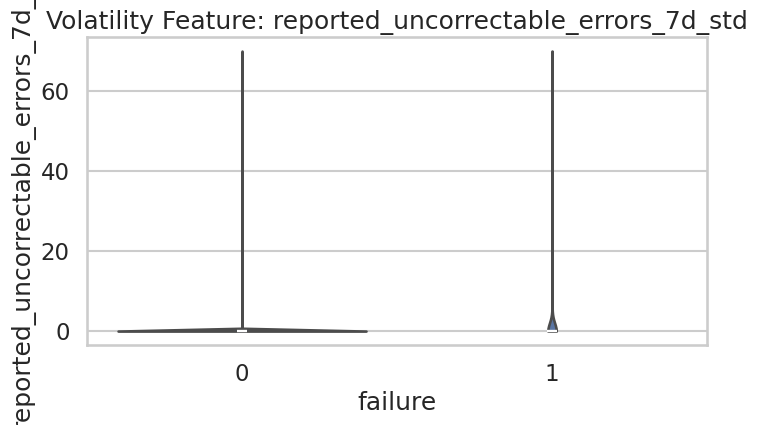

In [46]:
volatility_features = [f for f in top_features if "std" in f or "delta" in f]

for f in volatility_features:
    plt.figure(figsize=(8,4))
    sns.violinplot(x="failure", y=f, data=df, cut=0)
    plt.title(f"Volatility Feature: {f}")
    plt.show()


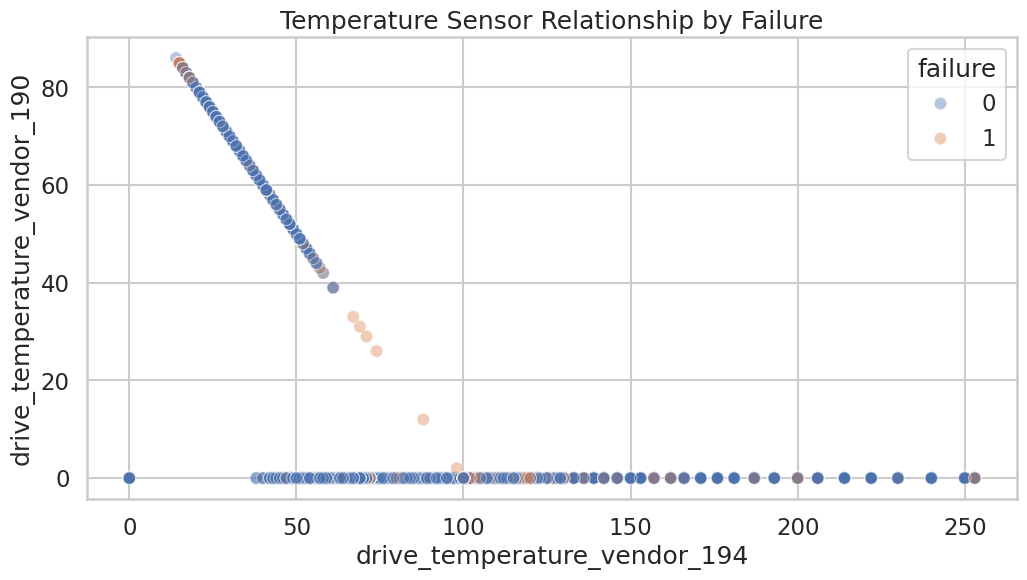

In [47]:
if "temp_stress" in df.columns:
    sns.scatterplot(
        x="drive_temperature_vendor_194",
        y="drive_temperature_vendor_190",
        hue="failure",
        data=df,
        alpha=0.4
    )
    plt.title("Temperature Sensor Relationship by Failure")
    plt.show()


In [48]:
print("Visual EDA complete for features:", top_features)


Visual EDA complete for features: ['command_timeout_count_7d_mean', 'drive_temperature_vendor_190_7d_mean', 'udma_crc_error_count_7d_mean', 'reported_uncorrectable_errors_7d_std', 'command_timeout_count_log', 'drive_temperature_vendor_190_log']


In [49]:
#Mann U test

stat_features = top_features  # from Option 1
from scipy.stats import mannwhitneyu

mw_results = []

for f in stat_features:
    x = df[df.failure == 1][f]
    y = df[df.failure == 0][f]

    stat, p = mannwhitneyu(x, y, alternative="two-sided")

    mw_results.append({
        "feature": f,
        "p_value": p,
        "median_non_failure": y.median(),
        "median_failure": x.median()
    })

mw_df = pd.DataFrame(mw_results).sort_values("p_value")
mw_df


feature  p_value  median_non_failure  \
3  reported_uncorrectable_errors_7d_std   0.0000              0.0000   
0         command_timeout_count_7d_mean   0.0000              0.0000   
4             command_timeout_count_log   0.0000              0.0000   
1  drive_temperature_vendor_190_7d_mean   0.0000              0.0000   
5      drive_temperature_vendor_190_log   0.0000              0.0000   
2          udma_crc_error_count_7d_mean   0.0000            200.0000   

   median_failure  
3          0.0000  
0        100.0000  
4          4.6151  
1         59.5000  
5          4.0943  
2        200.0000

In [50]:
import numpy as np

def cliffs_delta(x, y):
    return (np.sum(x[:, None] > y) - np.sum(x[:, None] < y)) / (len(x) * len(y))

effect_results = []

for f in stat_features:
    x = df[df.failure == 1][f].values[:3000]
    y = df[df.failure == 0][f].values[:3000]

    delta = cliffs_delta(x, y)

    effect_results.append({
        "feature": f,
        "cliffs_delta": delta
    })

effect_df = pd.DataFrame(effect_results).sort_values("cliffs_delta", ascending=False)
effect_df


feature  cliffs_delta
0         command_timeout_count_7d_mean        0.0067
4             command_timeout_count_log        0.0067
1  drive_temperature_vendor_190_7d_mean        0.0000
3  reported_uncorrectable_errors_7d_std        0.0000
5      drive_temperature_vendor_190_log        0.0000
2          udma_crc_error_count_7d_mean       -0.1906

In [51]:
# Modeling
from sklearn.model_selection import train_test_split

X = df[engineered_features]
y = df["failure"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train failure rate:", y_train.mean())
print("Test failure rate:", y_test.mean())


Train failure rate: 0.06250241173065792
Test failure rate: 0.06249155910555459


In [52]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, classification_report

logreg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

logreg.fit(X_train, y_train)

y_pred_prob_lr = logreg.predict_proba(X_test)[:, 1]
y_pred_lr = logreg.predict(X_test)

print("Logistic Regression PR-AUC:",
      average_precision_score(y_test, y_pred_prob_lr))

print(classification_report(y_test, y_pred_lr))


Logistic Regression PR-AUC: 0.46810193651125465
              precision    recall  f1-score   support

           0       0.98      0.75      0.85     48592
           1       0.17      0.75      0.27      3239

    accuracy                           0.75     51831
   macro avg       0.57      0.75      0.56     51831
weighted avg       0.93      0.75      0.81     51831



In [53]:
# Tree based model (XGBoost)
from xgboost import XGBClassifier

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_prob_xgb = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb.predict(X_test)

print("XGBoost PR-AUC:",
      average_precision_score(y_test, y_pred_prob_xgb))

print(classification_report(y_test, y_pred_xgb))


XGBoost PR-AUC: 0.537927657814722
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     48592
           1       0.18      0.77      0.29      3239

    accuracy                           0.76     51831
   macro avg       0.58      0.77      0.57     51831
weighted avg       0.93      0.76      0.82     51831



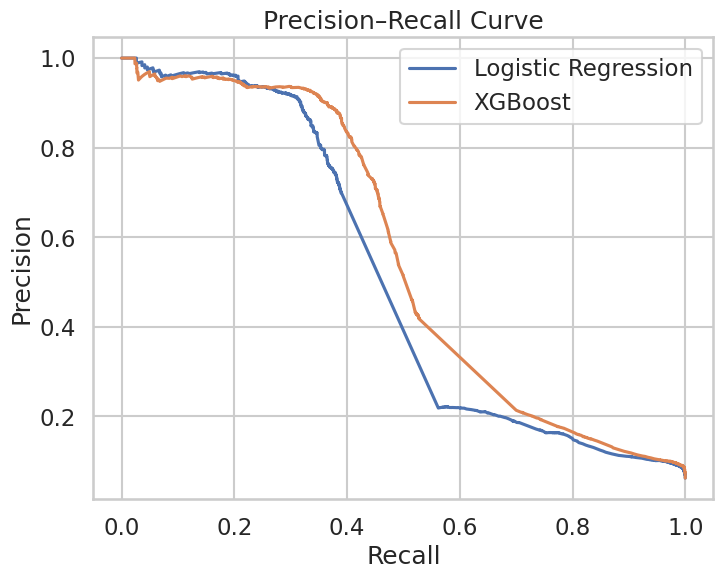

In [54]:
from sklearn.metrics import precision_recall_curve

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_prob_lr)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_prob_xgb)

plt.figure(figsize=(8,6))
plt.plot(recall_lr, precision_lr, label="Logistic Regression")
plt.plot(recall_xgb, precision_xgb, label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


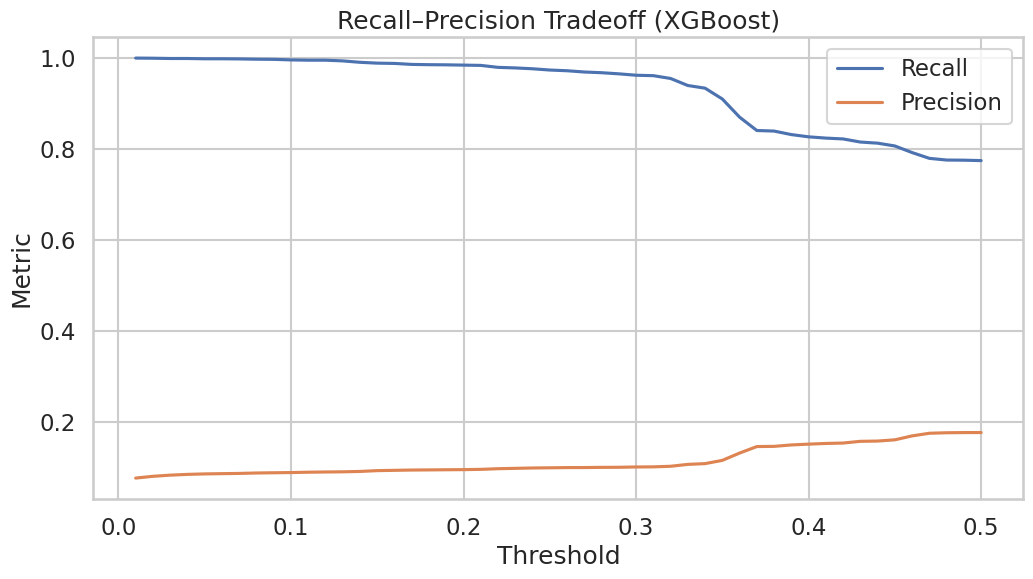

In [55]:
#Threshold tuning

import numpy as np

thresholds = np.linspace(0.01, 0.5, 50)

recalls = []
precisions = []

for t in thresholds:
    preds = (y_pred_prob_xgb >= t).astype(int)
    report = classification_report(y_test, preds, output_dict=True)
    recalls.append(report["1"]["recall"])
    precisions.append(report["1"]["precision"])

plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, precisions, label="Precision")
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.legend()
plt.title("Recall–Precision Tradeoff (XGBoost)")
plt.show()


In [56]:
#Feature importance
import pandas as pd

importance = pd.Series(
    xgb.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importance.head(15)


command_timeout_count_7d_mean              0.3484
reallocated_sector_count_cumulative        0.1571
reported_uncorrectable_errors_log          0.0780
reallocated_sector_count_7d_mean           0.0753
udma_crc_error_count_cumulative            0.0659
reported_uncorrectable_errors_delta        0.0324
reported_uncorrectable_errors_7d_mean      0.0246
udma_crc_error_count_log                   0.0238
command_timeout_count_log                  0.0229
udma_crc_error_count_7d_mean               0.0228
reallocated_sector_count_log               0.0205
reported_uncorrectable_errors_7d_std       0.0181
drive_temperature_vendor_194_7d_mean       0.0175
drive_temperature_vendor_194_log           0.0110
reported_uncorrectable_errors_cumulative   0.0100
dtype: float32

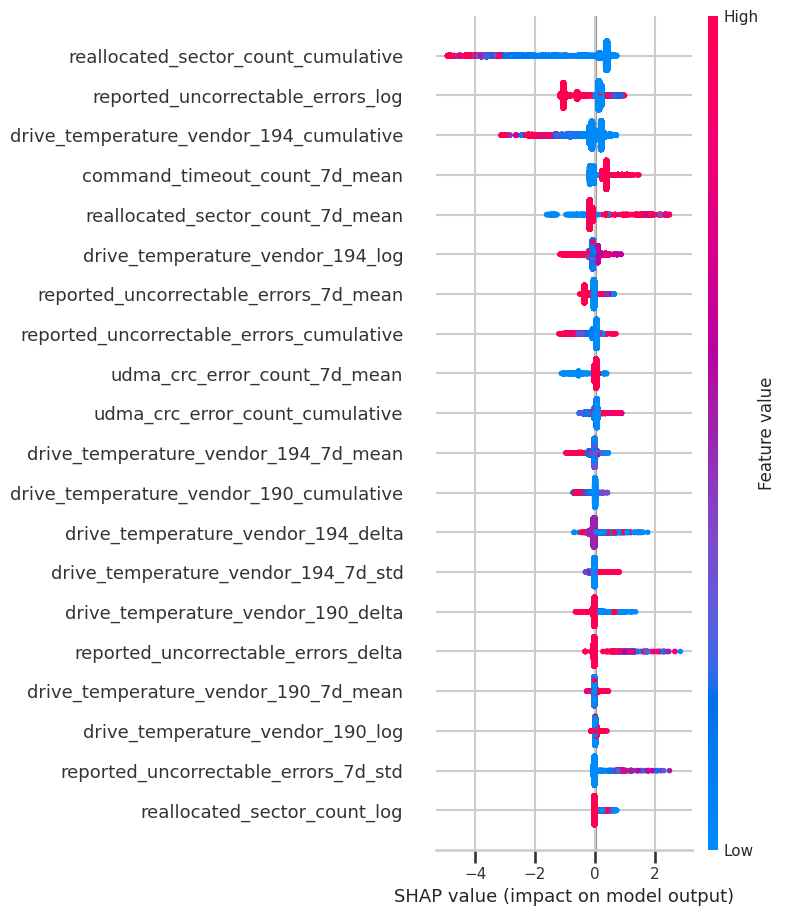

In [57]:
#SHAP ANALYSIS

import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
